In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
run_qs = RunStats.objects.filter(psearch__id=83, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

K  alpha  coherence  exclusivity  max_iter  rng_seed  run_id  \
0   20   0.01   0.400404     0.523049        50         1    2154   
1   45   0.05   0.514492     0.775650        50         1    2137   
2   45   0.01   0.493715     0.846099        50         1    2145   
3   45   0.05   0.370210     0.701541        50         1    2122   
4   45   0.10   0.506084     0.780998        50         1    2121   
5   45   0.10   0.491302     0.871996        50         1    2120   
6   50   0.01   0.496631     0.781455        50         1    2112   
7   45   0.10   0.416262     0.824821        50         1    2119   
8   45   0.01   0.508955     0.742253        50         1    2111   
9   45   0.05   0.480421     0.870453        50         1    2136   
10  45   0.10   0.374046     0.698753        50         1    2118   
11  45   0.01   0.362667     0.705540        50         1    2143   
12  45   0.01   0.400422     0.831657        50         1    2144   
13  40   0.01   0.454333     0.815445        50         1    2146   
14  40   0.05   0.460500     0.802809        50         1    2147   
15  45   0.05   0.410620     0.806679        50         1    2123   

    top_chain_var  
0           0.010  
1           0.005  
2           0.010  
3           0.100  
4           0.005  
5           0.010  
6           0.005  
7           0.050  
8           0.005  
9           0.010  
10          0.100  
11          0.100  
12          0.050  
13          0.010  
14          0.010  
15          0.050

In [3]:
run_id = 2155
# for ISIE talk: run_id = 1749

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3934749.14997559}


topic__id                      topic__title     totalscore
0      178515                        stop words  619234.291928
1      178481                      procedural 1  273809.686006
2      178498                 economic policy 1  202963.147750
3      178513                      procedural 2  142553.991272
4      178495                            europe  141410.998528
5      178489                      procedural 3  120756.670825
6      178497         general policy statements  116614.982983
7      178478           German-French coal plan  115945.235466
8      178484                            budget  110642.907628
9      178472                  green opposition  101886.271129
10     178507                           economy   94353.356143
11     178509        energy technology programs   93011.529199
12     178503  international climate protection   91341.266053
13     178511                    market economy   90148.767689
14     178487                 energy technology   88132.910751
15     178512                          budget 2   86829.668891
16     178482                      procedural 4   84658.875440
17     178496                   government debt   81174.204169
18     178505               federal coal policy   65641.395407
19     178501                 economic policy 2   63504.296502
20     178500                   energy carriers   61117.030144
21     178506                            Berlin   58929.585581
22     178490         international development   58699.905500
23     178480               nuclear phase out 1   58016.188575
24     178488                        job market   56826.351312
25     178477              coal mining industry   54859.450044
26     178486                             taxes   54725.612023
27     178485                    nuclear energy   53924.591530
28     178473                 diplomacy & trade   53409.953493
29     178493      structural adjustment policy   51097.977561
30     178471                 pollution control   50298.623636
31     178476                      east germany   49012.255815
32     178483            research & development   47390.412109
33     178492                  hard coal mining   46046.133560
34     178474                       agriculture   45163.333668
35     178502                    unions & firms   43998.818824
36     178510                          budget 3   43025.228524
37     178491               nature conservation   41864.699195
38     178479                         subsidies   41173.957979
39     178494              general politics 80s   37020.537646
40     178475               nuclear phase out 2   35383.944475
41     178504            financial equalization   33357.625107
42     178499                    housing policy   27932.794741
43     178508                  transport policy   26676.379494
44     178514                           pension   20183.305704

### Overall DocTopic score - Time plot

**test topics**: steinkohl, umweltschutz, international, forschung, saar 

In [4]:
dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))

<QuerySet [{'topic__title': 'agriculture', 'ut__document__parlperiod__n': 1, 'n': 3226.03005662859}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 2, 'n': 10713.3686501097}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 3, 'n': 5559.13767243005}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 4, 'n': 6982.99707471717}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 5, 'n': 9591.02869386289}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 6, 'n': 1056.8153349091}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 7, 'n': 560.611963570128}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 8, 'n': 769.262405478201}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 9, 'n': 662.971725742654}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 10, 'n': 1110.74694514383}, {'topic__title': 'agriculture', 'ut__document__parlperiod__n': 11, 'n': 1472.9321647745},

In [5]:
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_scores

topic             Berlin  German-French coal plan   agriculture        budget  \
parlperiod                                                                      
1           38662.514317             82180.699410   3226.030057  14777.766667   
2            8316.912258             17169.771031  10713.368650  18862.193420   
3            4250.540327              3258.547188   5559.137672  23009.948260   
4            1560.232728              2345.020718   6982.997075  16216.458648   
5            1823.080039              2570.841959   9591.028694  16329.219999   
6             330.314408               382.077638   1056.815335   3189.105459   
7             246.405048               440.005327    560.611964   3811.341367   
8             555.904122               554.419117    769.262405   2575.235631   
9             485.541333               932.894531    662.971726   1322.152075   
10            408.700826              1108.295543   1110.746945   1522.971984   
11            721.414218              1087.594315   1472.932165   2142.144915   
12            232.288318               749.952762    676.645488   1426.995446   
13            268.926730               579.144204    712.628222   1510.072979   
14            278.411089               638.068464    287.864045   1189.640484   
15             96.306194               363.921700    467.715864    631.040204   
16            134.282247               483.396877    489.162892    783.456420   
17            185.269154               469.410242    175.891942    483.760278   
18            187.773257               299.326020    374.783425    591.810393   
19            184.768969               331.848421    272.739102    267.593001   

topic           budget 2     budget 3  coal mining industry  \
parlperiod                                                    
1             449.016288   793.938198           1240.560173   
2             327.755928  1223.235144           1893.688399   
3             709.848779  1495.419598           6292.436745   
4             423.301524  1593.766447          13293.537586   
5             663.151899  3449.011919          21370.031326   
6             245.240418   701.891086           1094.356242   
7             528.141802  1609.113920           2036.556935   
8             543.461562  3400.651199           1839.230515   
9             514.587255  2107.224479            686.989834   
10            958.025838  2606.547480           1000.970169   
11           1748.613610  3424.268711           1233.565077   
12           1889.122669  3980.477722            996.344248   
13           8478.985322  8231.434063            805.194264   
14          15218.881648  3024.881231            200.675994   
15          25633.033709  1309.345187            305.714340   
16          16769.347693  1881.059043            231.120710   
17           6195.166619  1006.897595            267.349066   
18           3694.114731   756.613378             58.022041   
19           1839.871599   429.452124             13.106381   

topic       diplomacy & trade  east germany  economic policy 1  ...  \
parlperiod                                                      ...   
1                 2684.419407    625.503506        5259.184545  ...   
2                  909.885907    158.924212       10684.007392  ...   
3                 1479.101861    106.526944        8019.934955  ...   
4                  915.872907     37.038656        9186.302627  ...   
5                 2851.867421    116.560991       27116.786938  ...   
6                  655.165323     84.034250        4851.684845  ...   
7                 7655.084376    115.667869       15114.323769  ...   
8                12020.831346    256.478173       18791.329426  ...   
9                 6274.420043    337.999859       11286.923394  ...   
10                4360.578152    424.147554       18988.382118  ...   
11                2980.810971   3719.137218       17981.456607  ...   
12                3078.081048  19047.690972       1

In [6]:
# normalization
df_shares = df_scores.copy()
for i in df_shares.index:
    df_shares.loc[i] = df_scores.loc[i] / df_scores.loc[i].sum() * 100
df_shares

topic          Berlin  German-French coal plan  agriculture     budget  \
parlperiod                                                               
1           11.013259                23.409687     0.918955   4.209539   
2            3.183096                 6.571313     4.100282   7.219047   
3            2.278761                 1.746942     2.980314  12.335882   
4            1.088262                 1.635652     4.870640  11.310978   
5            0.660432                 0.931317     3.474460   5.915447   
6            0.527005                 0.609592     1.686112   5.088106   
7            0.135663                 0.242253     0.308655   2.098401   
8            0.216945                 0.216365     0.300209   1.005001   
9            0.305962                 0.587859     0.417769   0.833148   
10           0.141633                 0.384074     0.384923   0.527777   
11           0.246542                 0.371683     0.503372   0.732074   
12           0.101290                 0.327018     0.295052   0.622243   
13           0.103371                 0.222613     0.273922   0.580447   
14           0.147866                 0.338881     0.152886   0.631824   
15           0.067234                 0.254062     0.326524   0.440544   
16           0.062220                 0.223982     0.226654   0.363015   
17           0.109543                 0.277546     0.103999   0.286031   
18           0.117478                 0.187270     0.234480   0.370260   
19           0.167591                 0.300997     0.247383   0.242716   

topic        budget 2  budget 3  coal mining industry  diplomacy & trade  \
parlperiod                                                                 
1            0.127905  0.226158              0.353381           0.764674   
2            0.125441  0.468164              0.724763           0.348237   
3            0.380558  0.801711              3.373443           0.792963   
4            0.295253  1.111652              9.272241           0.638821   
5            0.240234  1.249444              7.741539           1.033122   
6            0.391273  1.119843              1.746007           1.045293   
7            0.290778  0.885926              1.121262           4.214641   
8            0.212089  1.327125              0.717771           4.691203   
9            0.324265  1.327858              0.432904           3.953798   
10           0.331999  0.903284              0.346881           1.511134   
11           0.597585  1.170237              0.421568           1.018686   
12           0.823755  1.735693              0.434457           1.342202   
13           3.259181  3.164026              0.309503           0.511190   
14           8.082824  1.606529              0.106580           0.761195   
15          17.895033  0.914085              0.213426           0.364047   
16           7.770091  0.871590              0.107090           0.707277   
17           3.662992  0.595344              0.158074           0.667322   
18           2.311186  0.473368              0.036301           0.647781   
19           1.668823  0.389527              0.011888           0.515904   

topic       east germany  economic policy 1  ...  procedural 2  procedural 3  \
parlperiod                                   ...                               
1               0.178179           1.498112  ...      7.696562      1.154364   
2               0.060824           4.089045  ...      6.852582      2.260371   
3               0.057110           4.299574  ...      4.440546      3.106795   
4               0.025834           6.407445  ...      4.548918      2.930748   
5               0.042226           9.823367  ...      4.794351      4.400959   
6               0.134074           7.740694  ...      4.540758     13.582043   
7               0.063683           8.321456  ...      4.074726      9.425738   
8               0.100092           7.333431  ...      4.152894      3.010211   
9               0.212989           7.112404  ...

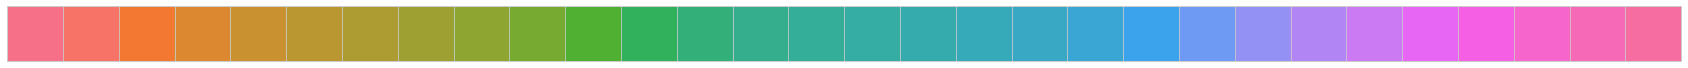

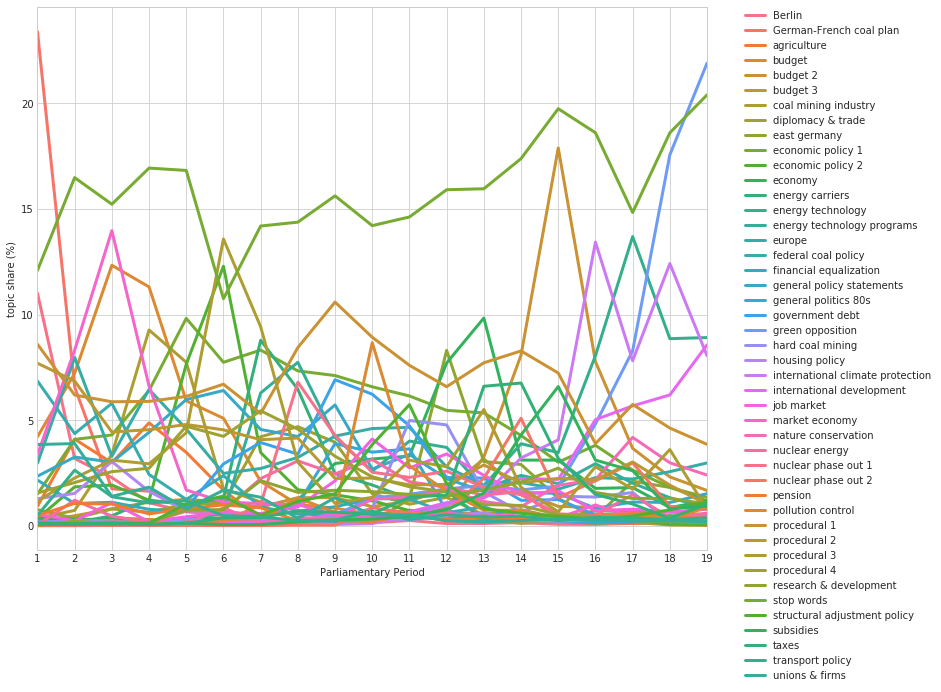

In [7]:
%matplotlib inline
# figure aesthetics
sns.set_style('whitegrid')
plt.rcParams['lines.linewidth'] = 3

sns.set_palette('husl', 30)
#sns.set_palette('muted')
sns.palplot(sns.color_palette())

ax = df_shares.plot(figsize=(12,10), xticks = df_shares.index)
ax.set(xlabel='Parliamentary Period', ylabel='topic share (%)')

fig = plt.gcf()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('dtopicscore_topic_comparison.png')

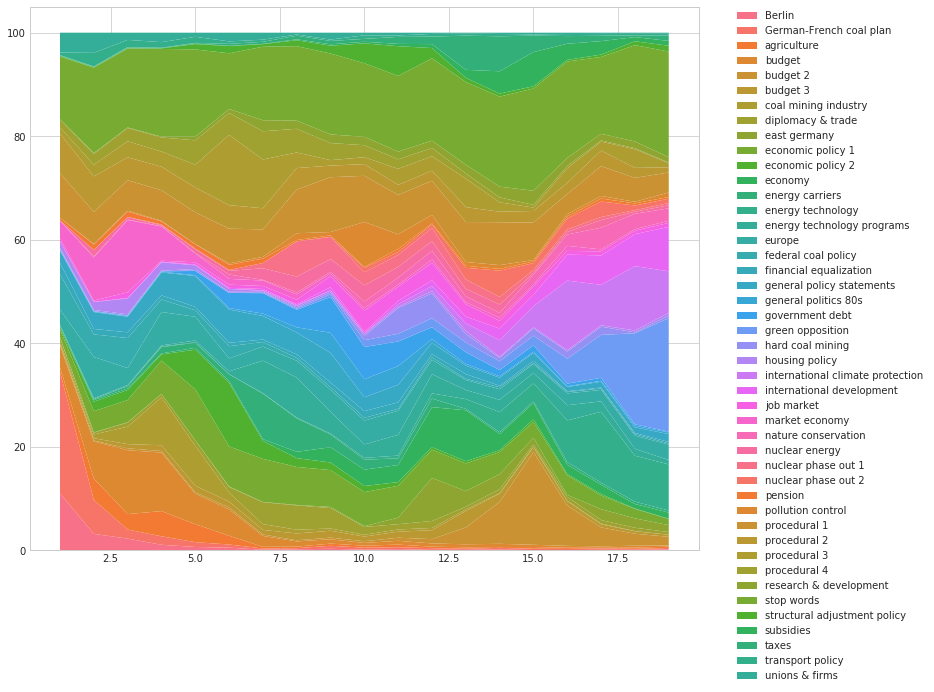

In [8]:
fig = plt.figure(figsize=(12,10))
plt.stackplot(df_shares.index, df_shares.T, labels=df_shares.columns)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

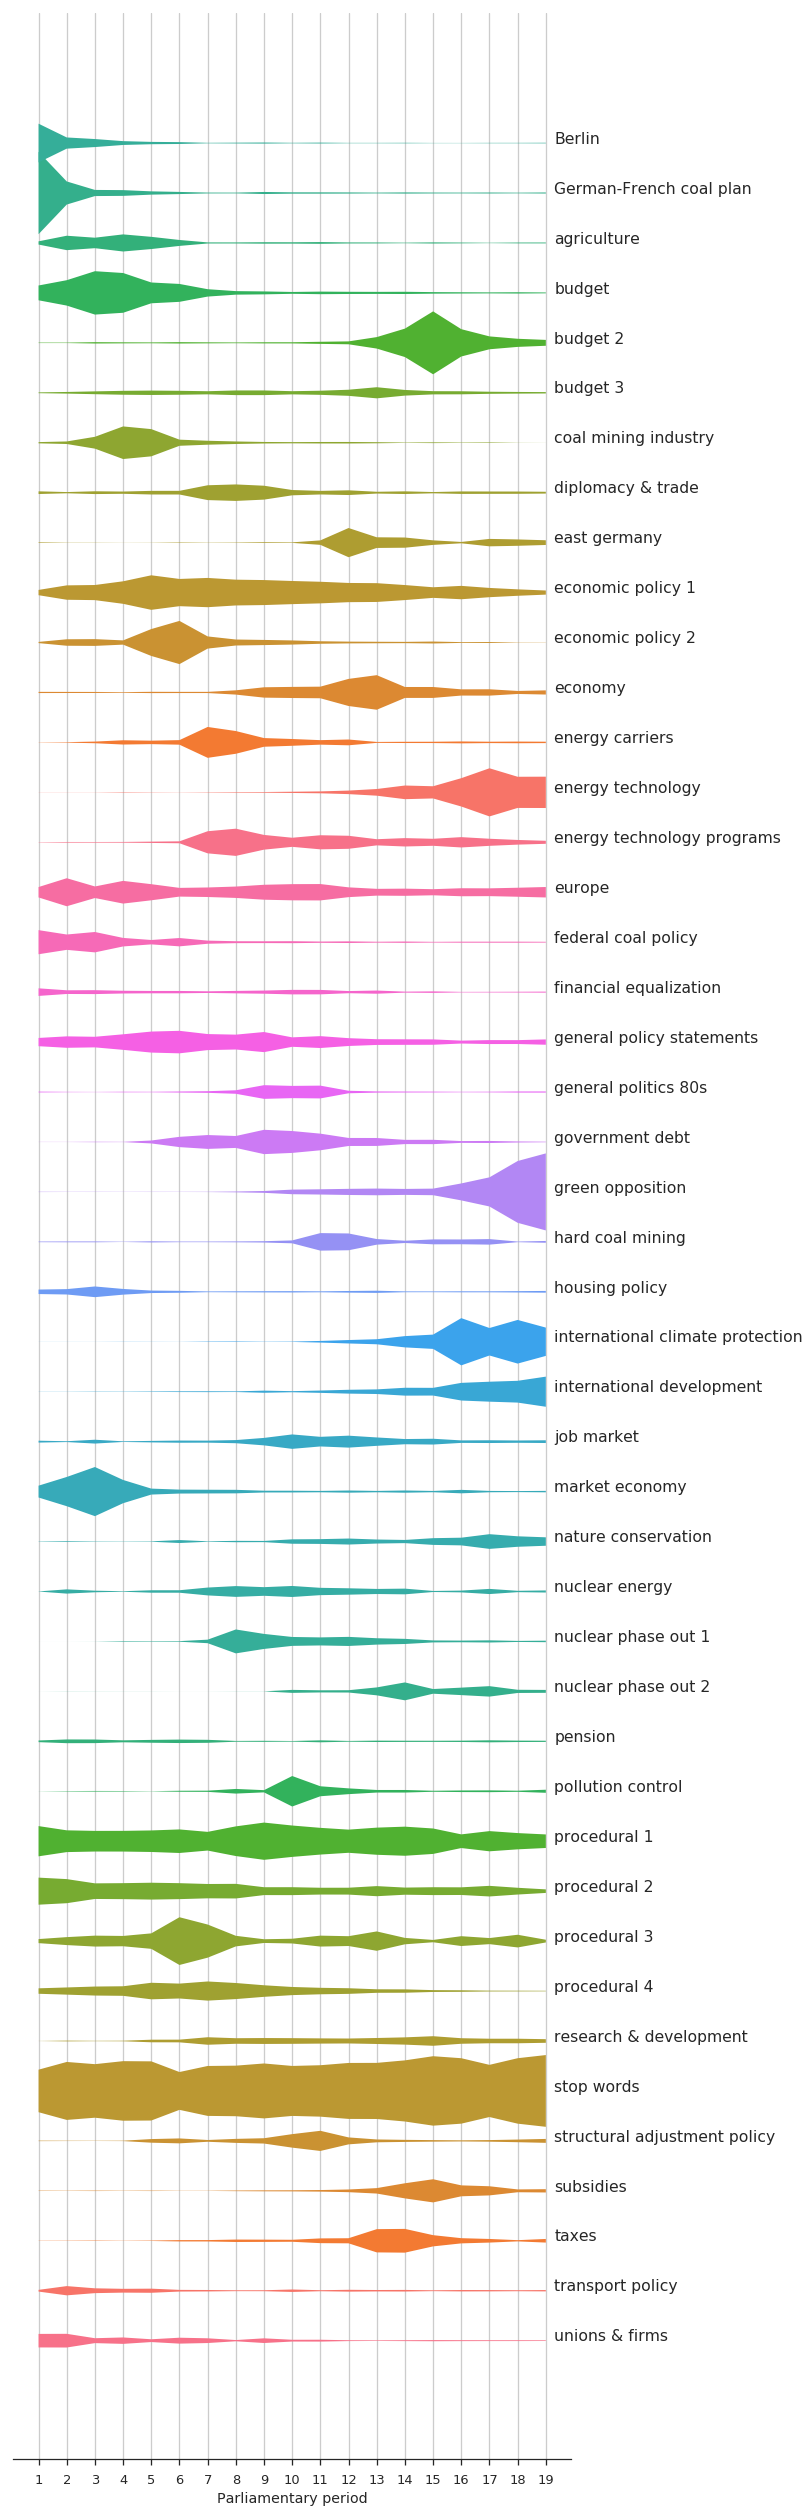

In [9]:
#dfs = df[["EU", "finance"]]
#dfs = df_shares[["hard coal mining",  "EU", "energy transition 3", "energy transition 2", "energy transition",
#          "economy & jobs", "east germany", "development", "climate protection", "climate policy"]]
#print(dfs)

dfs = df_shares[["agriculture", "coal mining industry", "diplomacy & trade",
                 "east germany", "energy technology", "federal coal policy",
                 "hard coal mining", "international climate protection", "nuclear phase out 2",
                 "pollution control", "research & development", "subsidies", "taxes"]]

dfs = df_shares

sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid':True,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
               'ytick.left': False})


fig = plt.figure(figsize=(10, len(dfs.columns)))
ax = fig.gca()
#ax.autoscale(enable=False)
#ax.set_ylim([0 - max_val, len(dfs.index) + max_val])
#ax.set(ylim=(0 - max_val, len(dfs.index) + max_val))
plt.yticks([])
plt.xticks(range(1,20))

max_val = dfs.max().max() + 5
#print(max_val)

for i, t in enumerate(reversed(dfs.columns)):
    plt.fill_between(dfs.index, dfs[t] + i*max_val, i*max_val - dfs[t], label=t)
    plt.text(19.3, (i+0.) *max_val, t)

plt.xlabel('Parliamentary period')
plt.savefig(os.path.join(save_dir, 'topic_evolution_run{}_all.png'.format(run_id)), dpi=150, bbox_inches="tight")


---

### Party Analysis

In [10]:
topic_id = 177242
topic_label = Topic.objects.get(id=topic_id).title
t1_party_totals = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=topic_id,
                 then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )),
    total_score=Sum('doctopic__score'),
).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
    'document__parlperiod__n', #parlperiod
    'topic_score', #doctopicscore
    'total_score',
    'topic_proportion',
    'speaker__party__id',
    'speaker__party__name',
    'speaker__party__colour'
).order_by('-document__parlperiod__n')

dft = pd.DataFrame.from_dict(list(t1_party_totals))
dft

document__parlperiod__n speaker__party__colour  speaker__party__id  \
0                        19                #009EE0                 112   
1                        19                #000000                 107   
2                        19                #FFED00                 109   
3                        19                #64A12D                 111   
4                        19                #8C3473                 108   
5                        19                #EB001F                 110   
6                        18                #000000                 107   
7                        18                #64A12D                 111   
8                        18                #8C3473                 108   
9                        18                #EB001F                 110   
10                       17                #000000                 107   
11                       17                #FFED00                 109   
12                       17                #64A12D                 111   
13                       17                #8C3473                 108   
14                       17                #EB001F                 110   
15                       16                #000000                 107   
16                       16                #FFED00                 109   
17                       16                #64A12D                 111   
18                       16                #8C3473                 108   
19                       16                #EB001F                 110   
20                       15                #000000                 107   
21                       15                #FFED00                 109   
22                       15                #64A12D                 111   
23                       15                #8C3473                 108   
24                       15                #EB001F                 110   
25                       14                #000000                 107   
26                       14                #FFED00                 109   
27                       14                #64A12D                 111   
28                       14                #8C3473                 108   
29                       14                #EB001F                 110   
..                      ...                    ...                 ...   
46                       10                #64A12D                 111   
47                       10                #EB001F                 110   
48                        9                #000000                 107   
49                        9                #FFED00                 109   
50                        9                #8C3473                 108   
51                        9                #EB001F                 110   
52                        8                #000000                 107   
53                        8                #FFED00                 109   
54                        8                #EB001F                 110   
55                        7                #000000                 107   
56                        7                #FFED00                 109   
57                        7                #EB001F                 110   
58                        6                #000000                 107   
59                        6                #FFED00                 109   
60                        6                #EB001F                 110   
61                        5                #000000                 107   
62                        5                #FFED00                 109   
63                        5                #EB001F                 110   
64                        4                #000000                 107   
65                        4                #FFED00                 109   
66                        4                #EB001F                 110   
67                        3                #000000                 107   
68      

In [11]:
# from parliament/views.py

# note: speaker__party__colour__isnull=False prevents loading data for other parties

def get_table_for_party_plots(topic_id):
    
    topic_label = Topic.objects.get(id=topic_id).title
    t1_party_totals = pm.Utterance.objects.filter(
        doctopic__topic__run_id=run_id, 
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False
    ).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=topic_id,
                     then=F('doctopic__score')),
                default=0,
                output_field=models.FloatField()
            )),
        total_score=Sum('doctopic__score'),
    ).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
        'document__parlperiod__n', #parlperiod
        'topic_score', #doctopicscore
        'total_score',
        'topic_proportion',
        'speaker__party__id',
        'speaker__party__name',
        'speaker__party__colour'
    ).order_by('-document__parlperiod__n')
    
    dft = pd.DataFrame.from_dict(list(t1_party_totals))
    dft.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
    dft_score = pd.DataFrame([dft['parlperiod'], dft['party_name'], dft['doctopic_score']]).transpose()
    dft_score = dft_score.pivot(index='parlperiod', columns='party_name', values='doctopic_score')
    
    dft_proportion = pd.DataFrame([dft['parlperiod'], dft['party_name'], dft['doctopic_proportion']]).transpose()
    dft_proportion = dft_proportion.pivot(index='parlperiod', columns='party_name', values='doctopic_proportion')
    
    return dft_score, dft_proportion

In [12]:
# Stacked bar plot scores
def stacked_bar_plot_party(df, topic_label, filename="", pct=False, value_name="DocTopic score"):
    
    if pct:
        df_plot = df.copy()
        for i in df_plot.index:
            df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
        ylabel = '% of {}'.format(value_name)
        title_str = "Percentage of {} per party for '{}'".format(value_name, topic_label)
    
    else:
        ylabel = value_name
        title_str = "{} per party for '{}'".format(value_name, topic_label)
        df_plot = df
        
    ax = df_plot.plot(kind='bar', stacked=True, # title=topic_names[0],
                     figsize=(10,8), xticks = df_plot.index)
    
    ax.set(xlabel='Parliamentary Period', ylabel=ylabel, title=title_str)
    
    if pct:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(title="")
        
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")


# Stacked bar plot percent scores
def stacked_bar_plot_party_scores_pct_of_all(df, df_scores, topic_label, filename=""):
    
    dft_shares = df.copy()
    for i in dft_shares.index:
        dft_shares.loc[i] = dft_shares.loc[i] / df_scores.loc[i].sum() * 100

    ax = dft_shares.plot(kind='bar', stacked=True, # title=topic_names[0],
                     figsize=(10,8), xticks = dft_shares.index)
    ax.set(xlabel='Parliamentary Period', ylabel='% of total topic scores', title="{}".format(topic_label))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(title="")

    fig = plt.gcf()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")


# manual setting of colour, needs to be adjusted with new party or order change 
party_colour = ["#0088FF", "#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]
sns.set_palette(party_colour)
sns.set_context('talk')

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


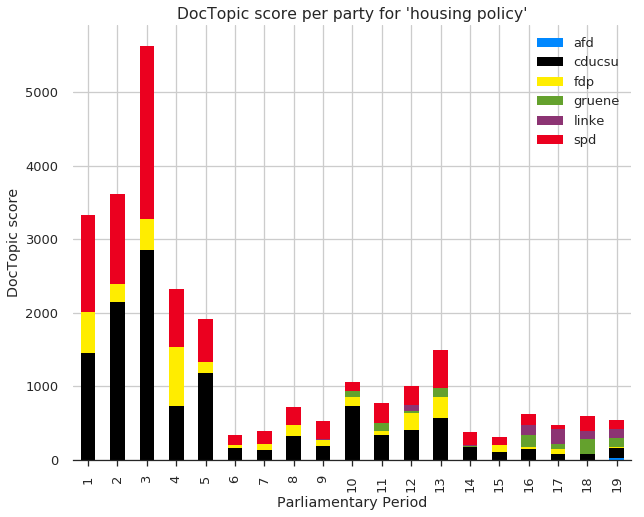

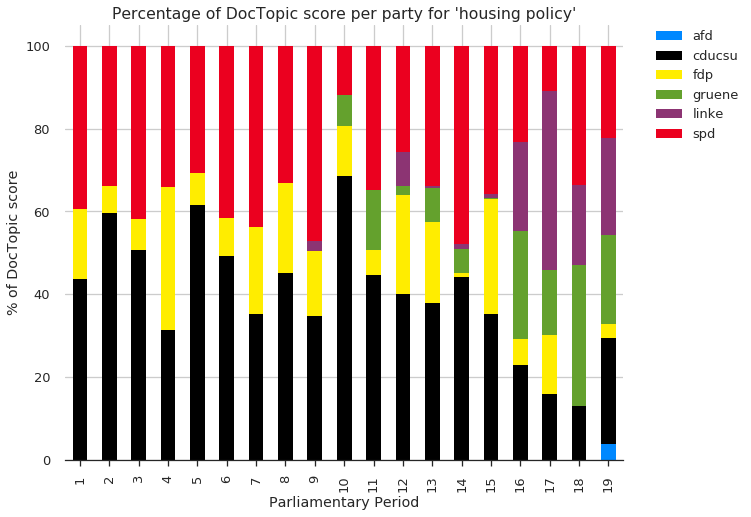

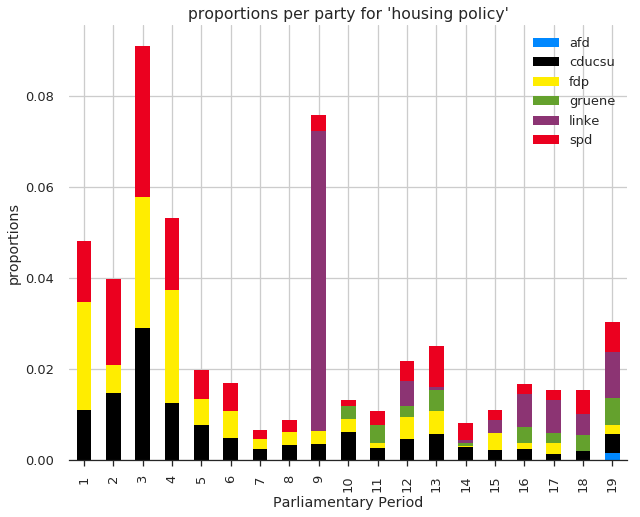

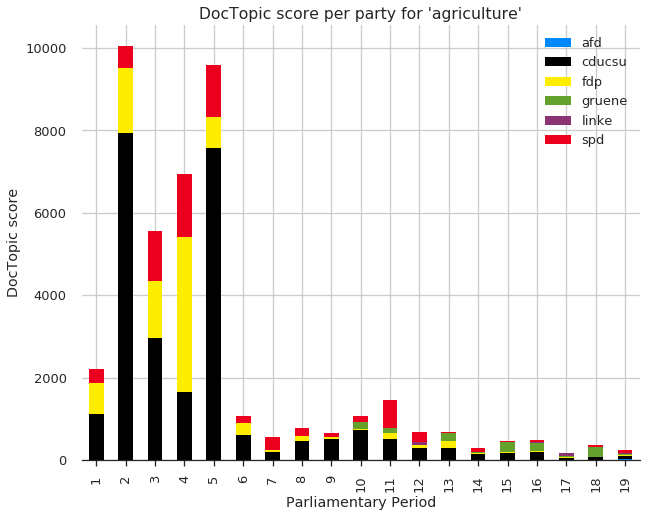

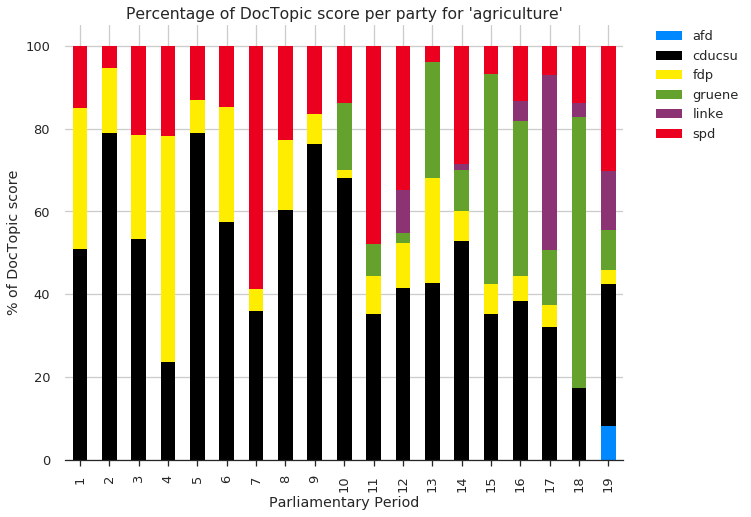

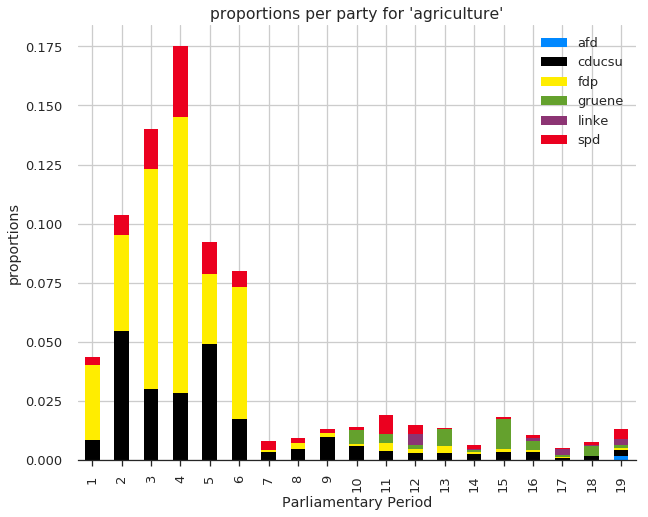

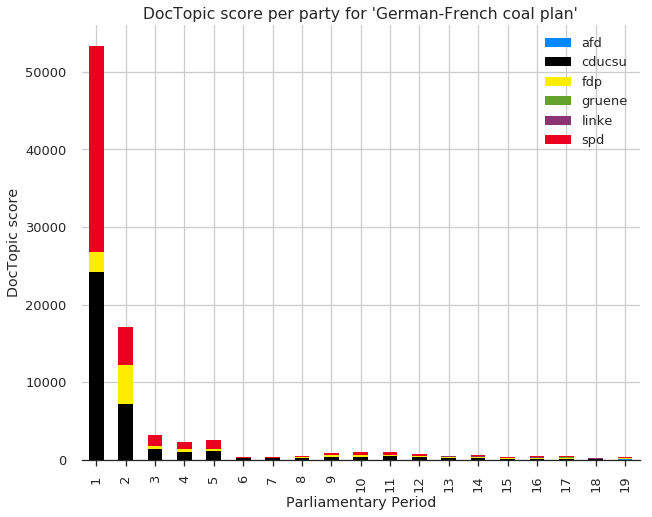

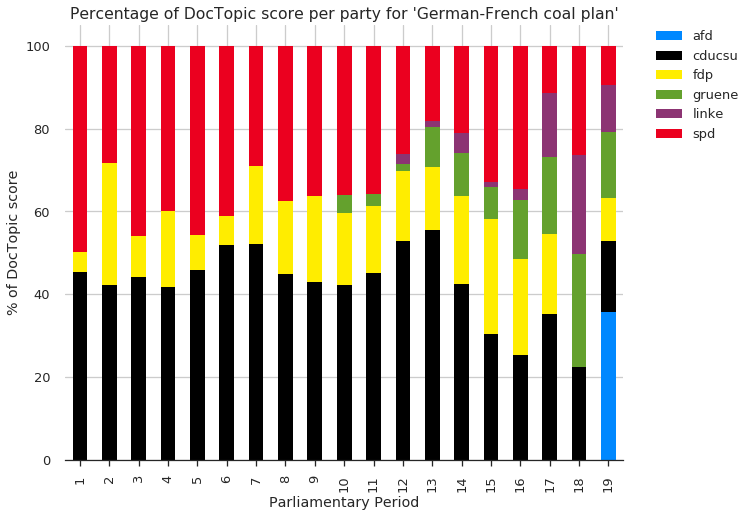

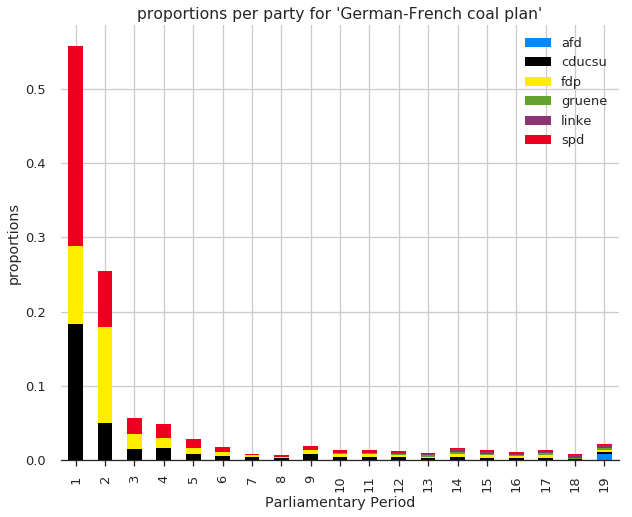

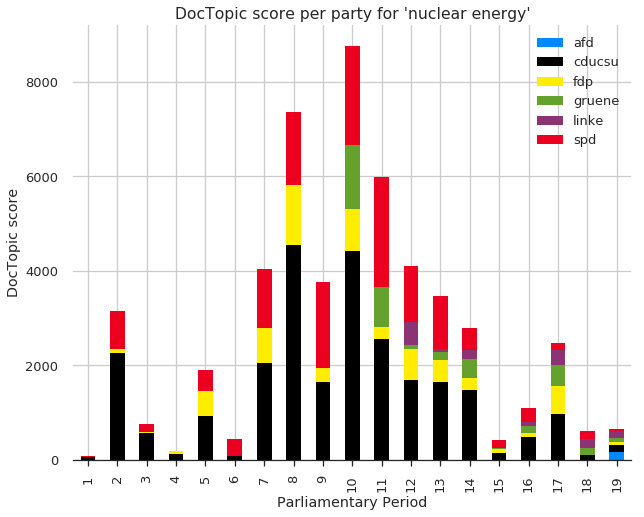

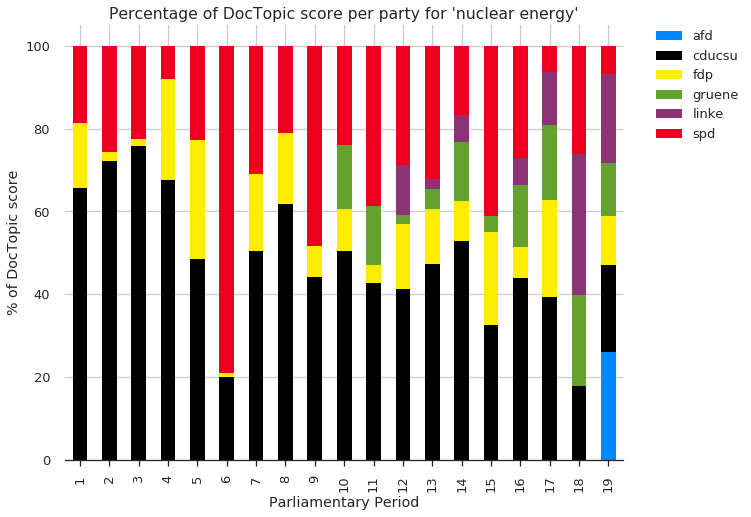

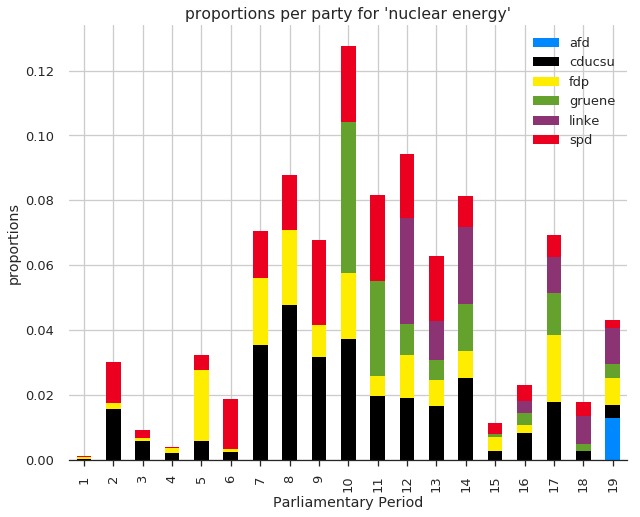

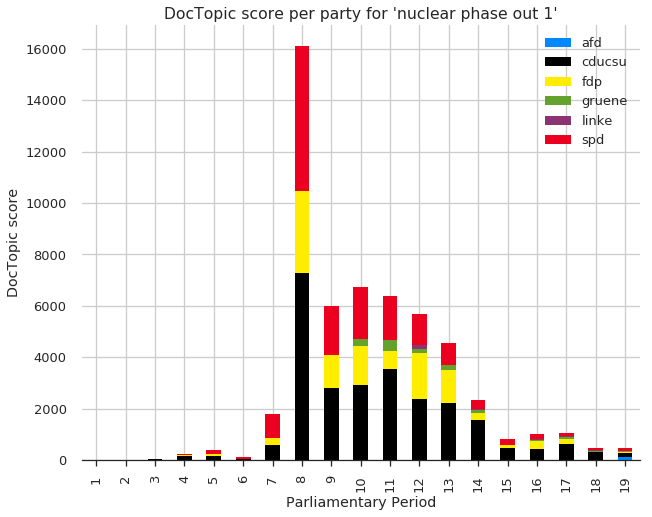

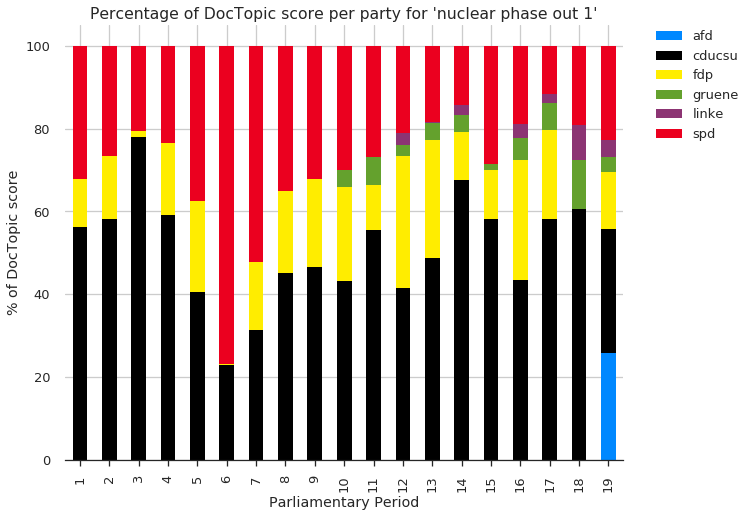

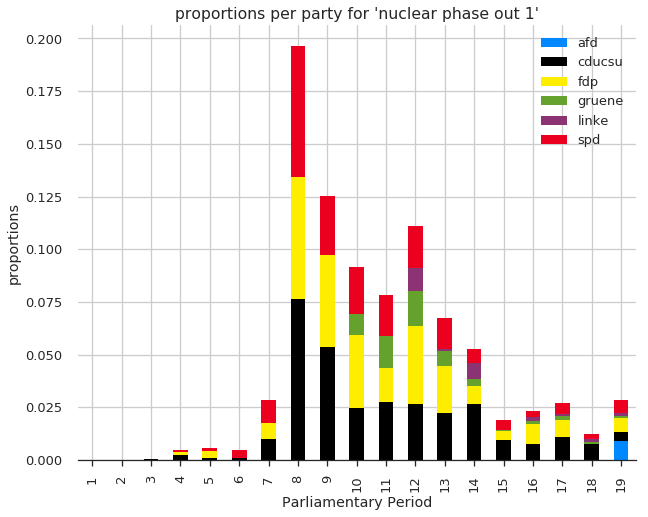

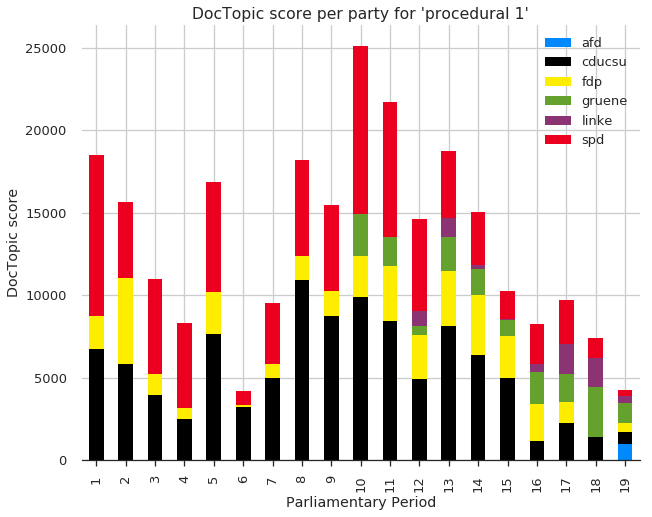

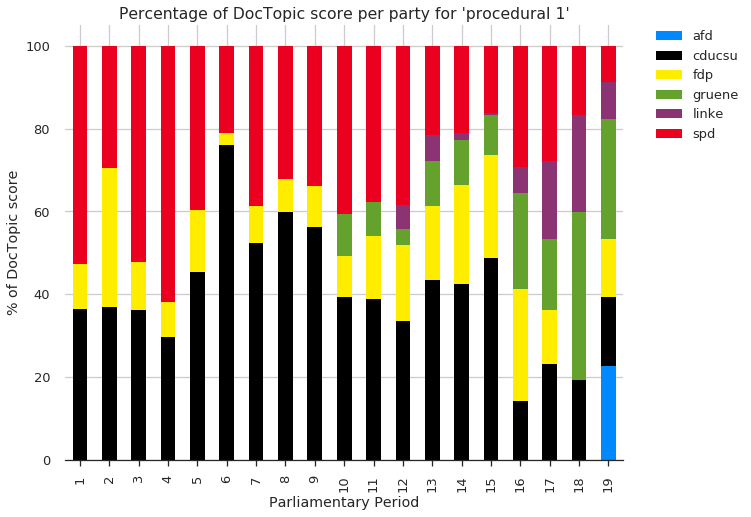

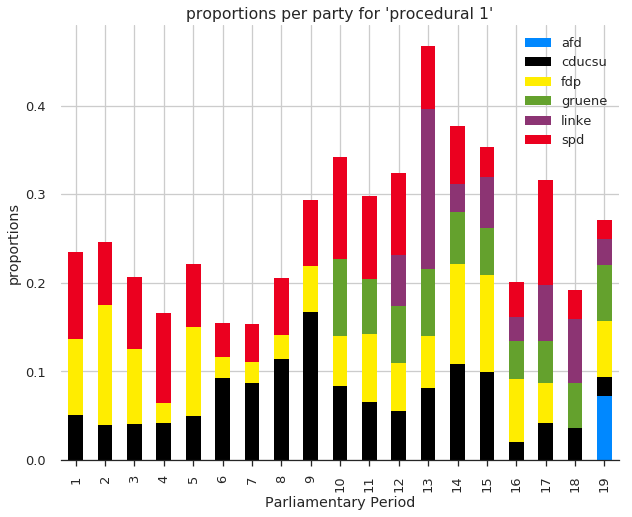

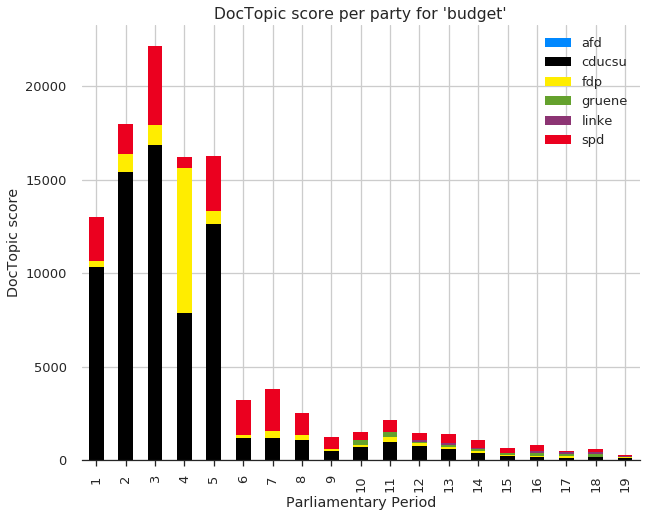

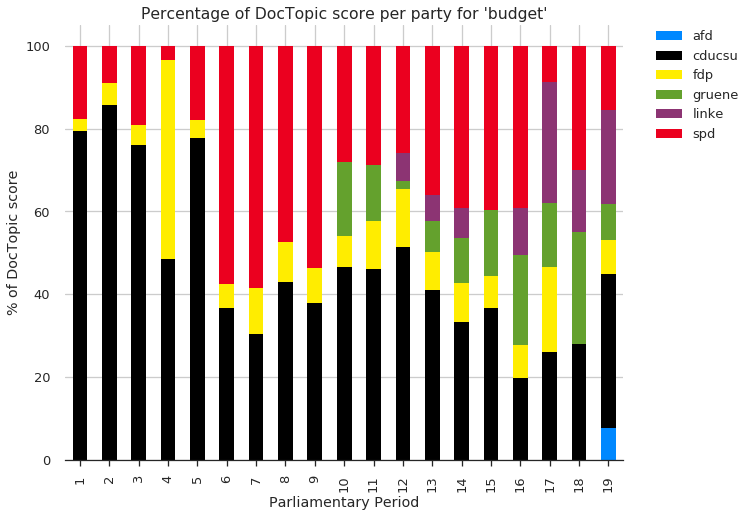

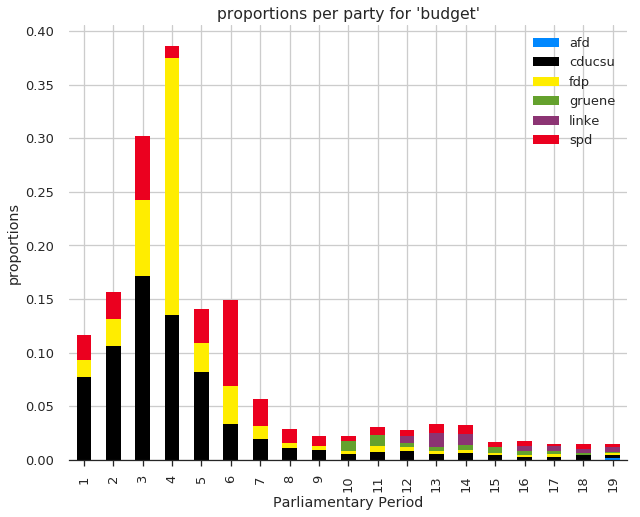

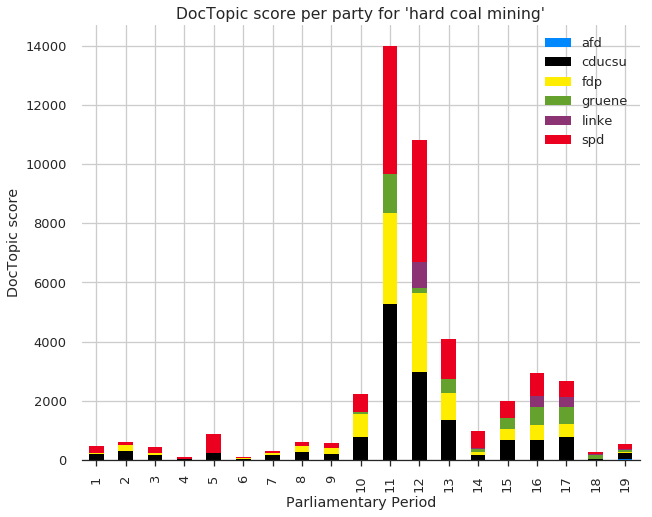

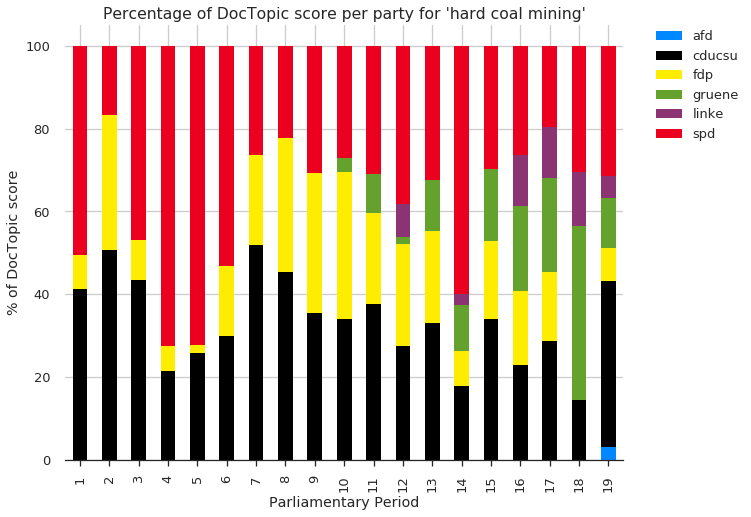

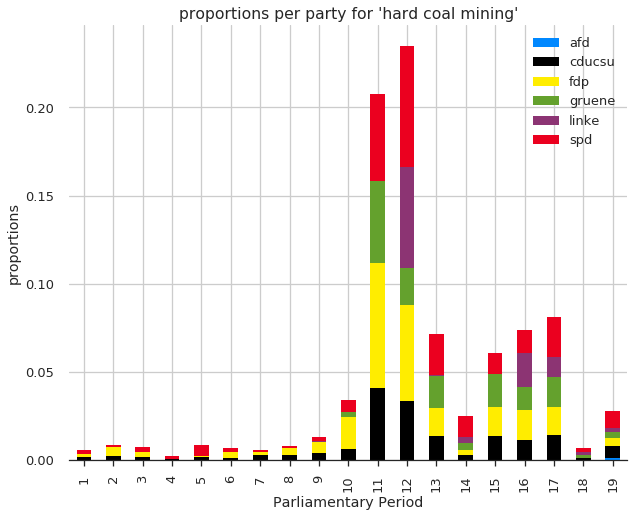

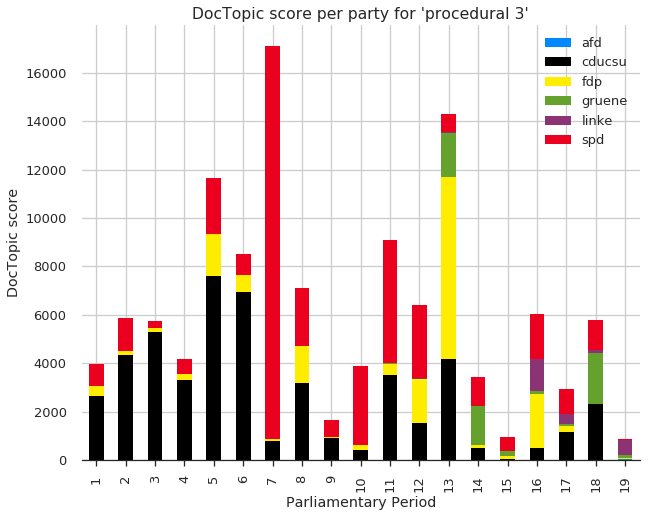

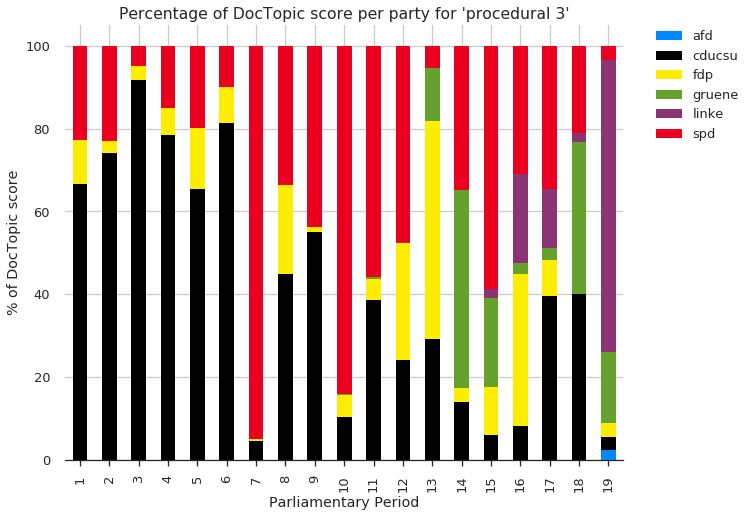

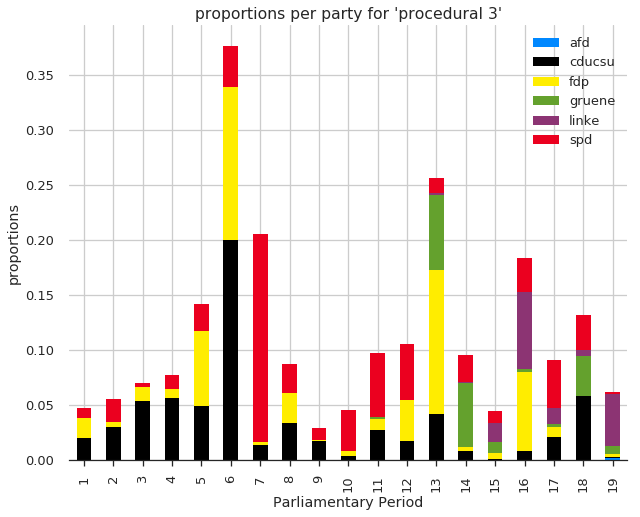

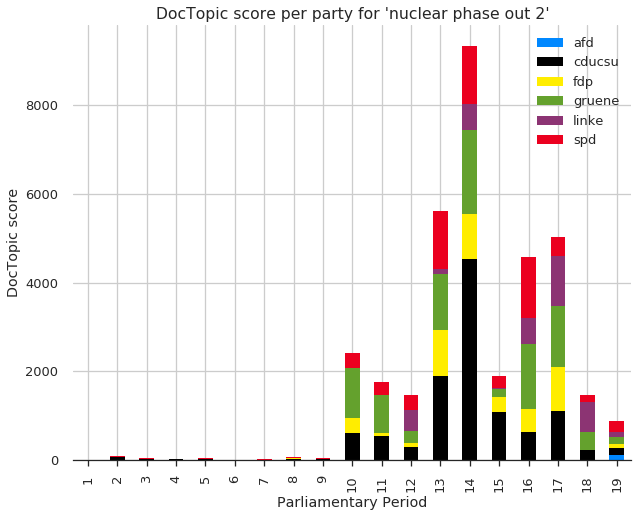

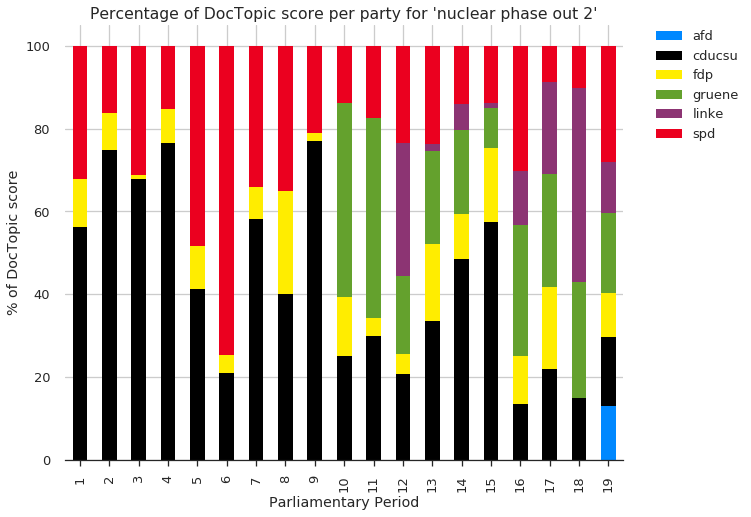

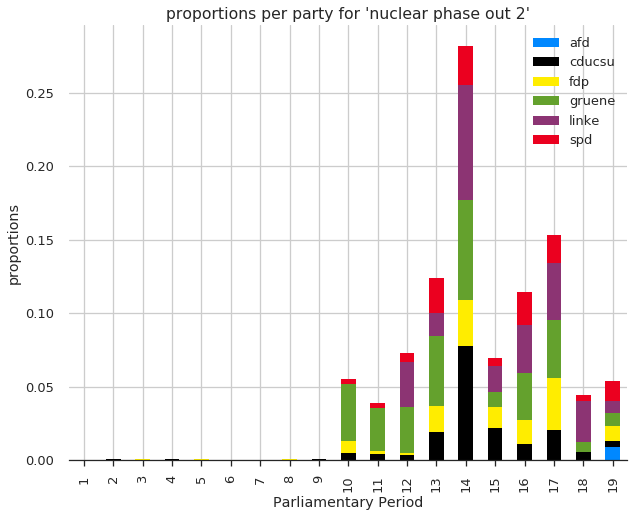

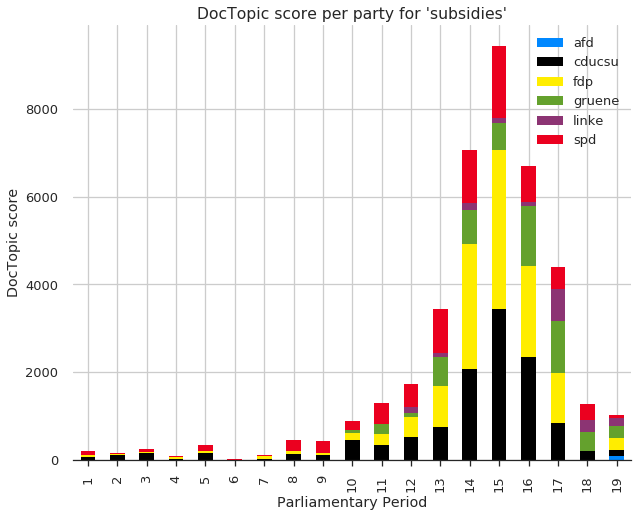

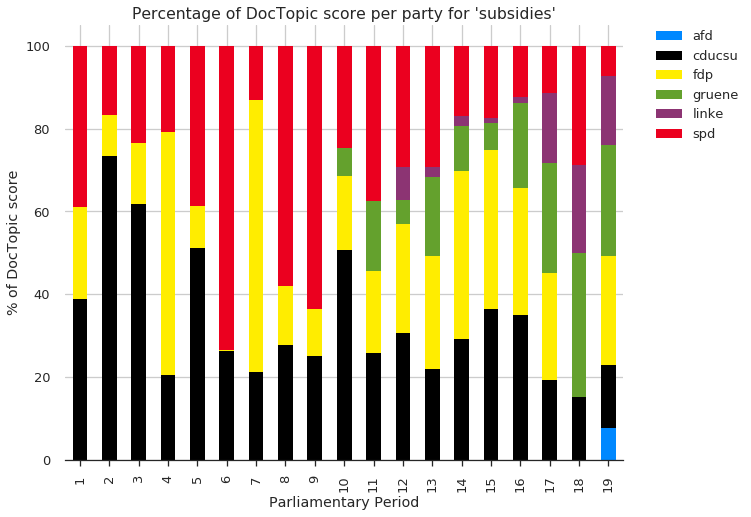

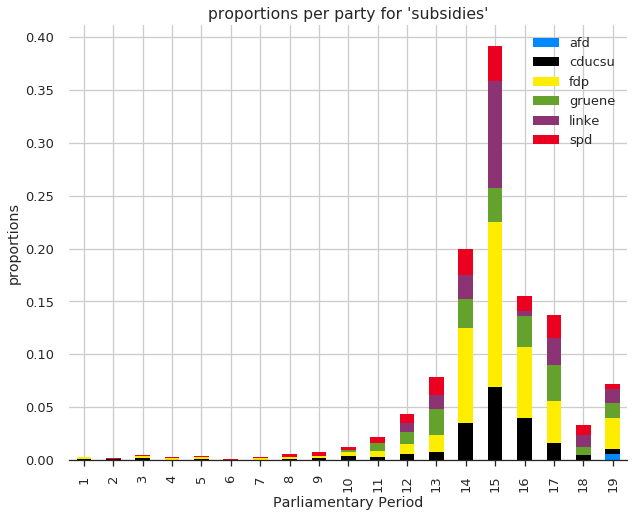

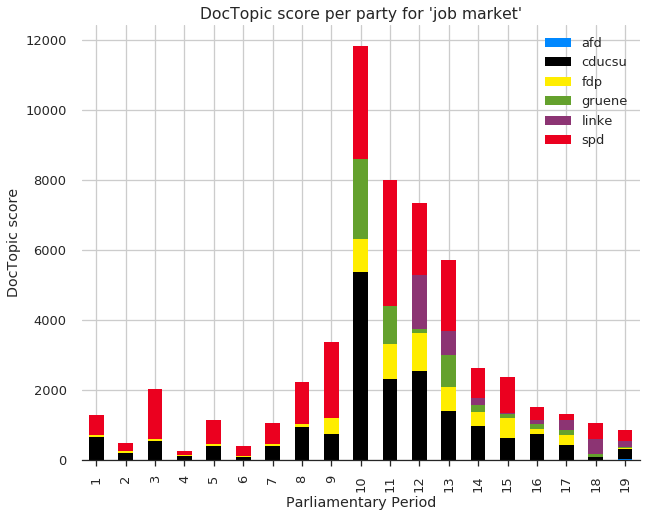

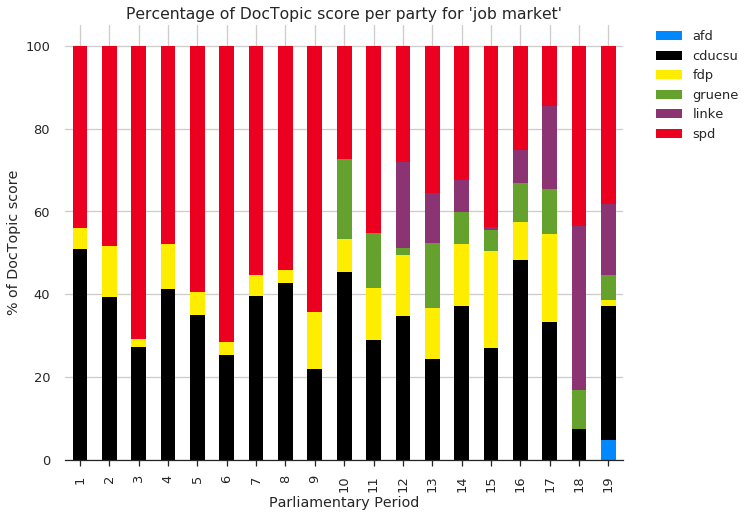

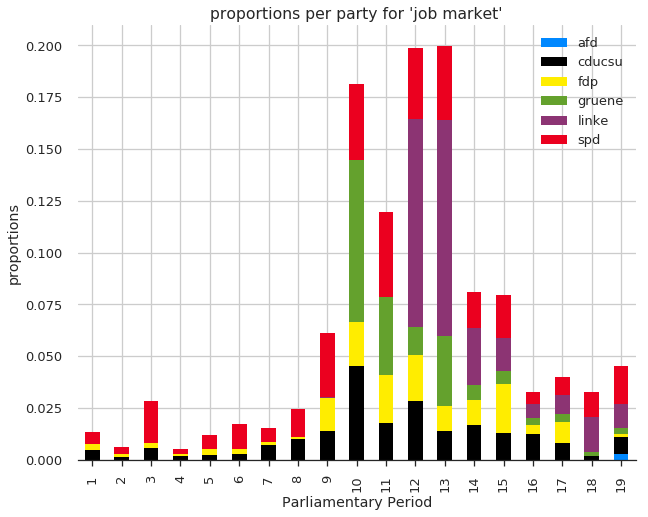

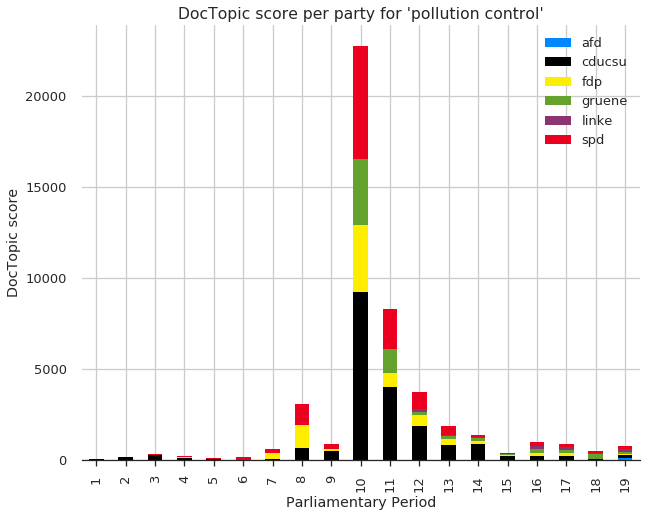

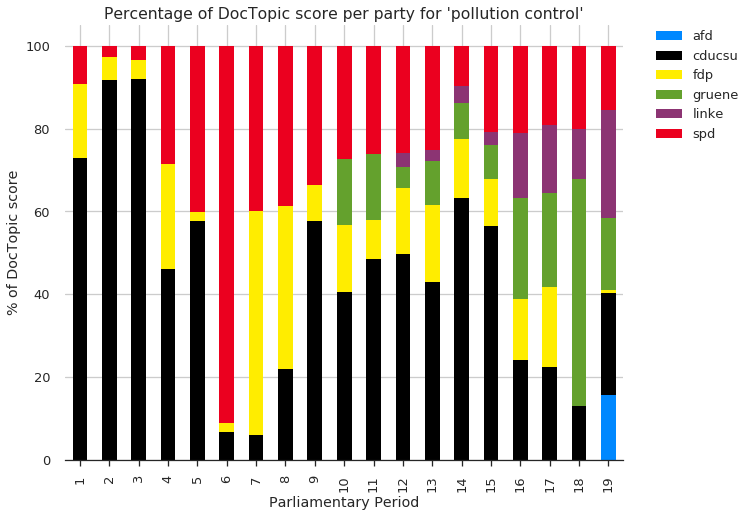

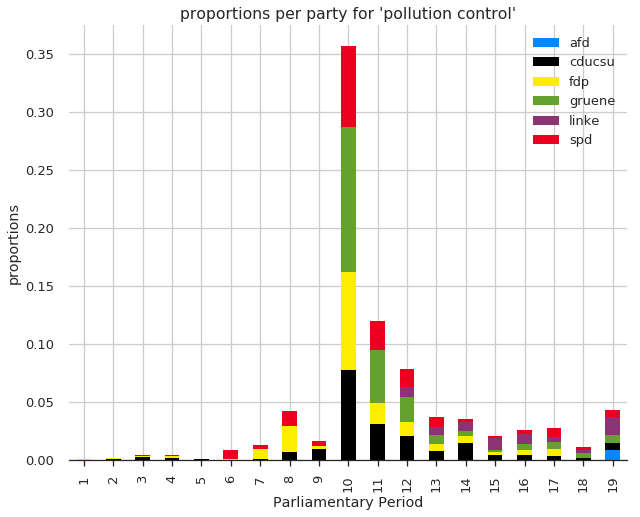

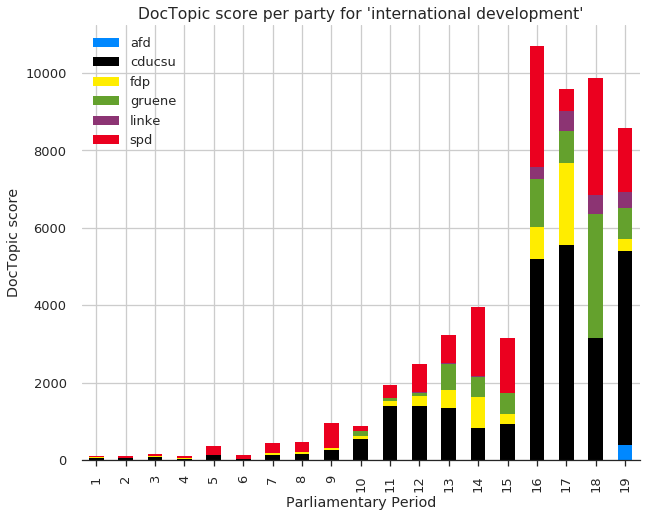

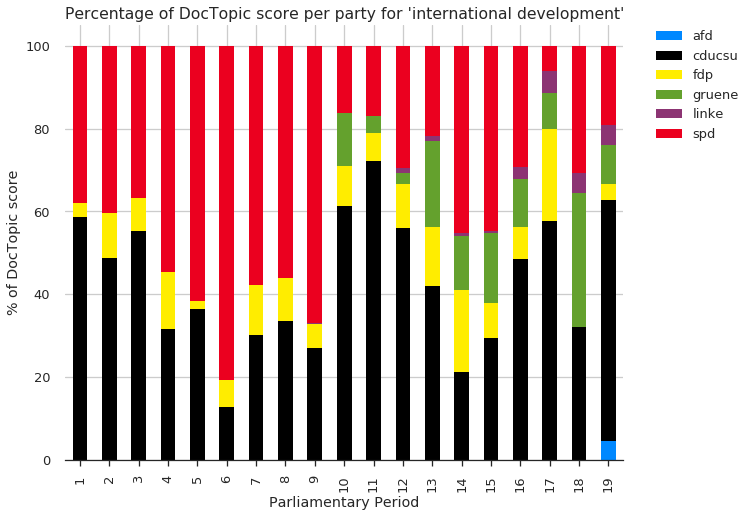

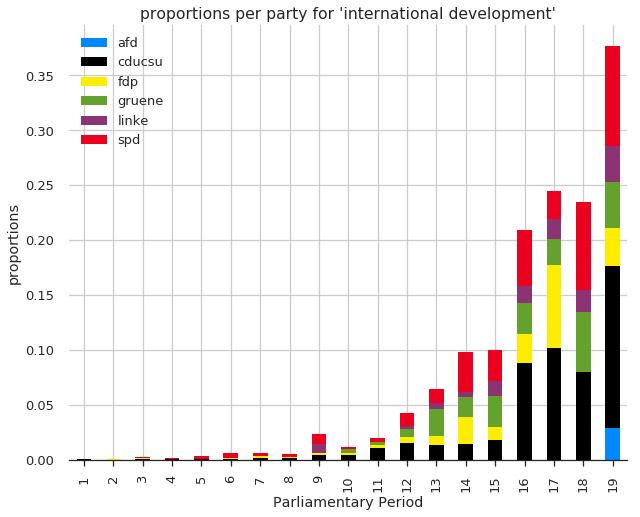

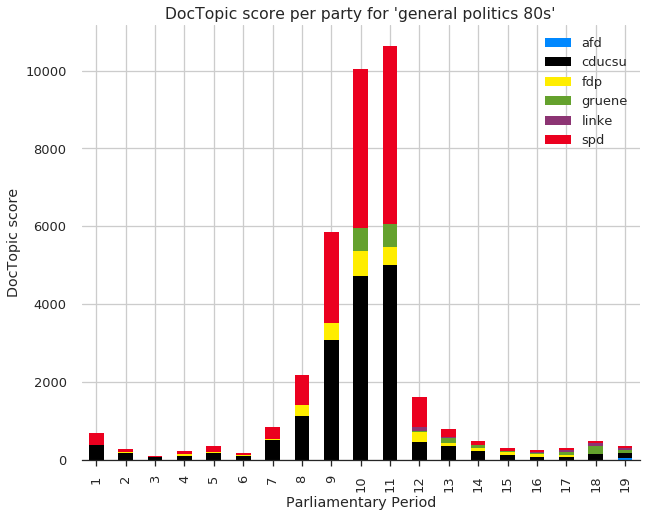

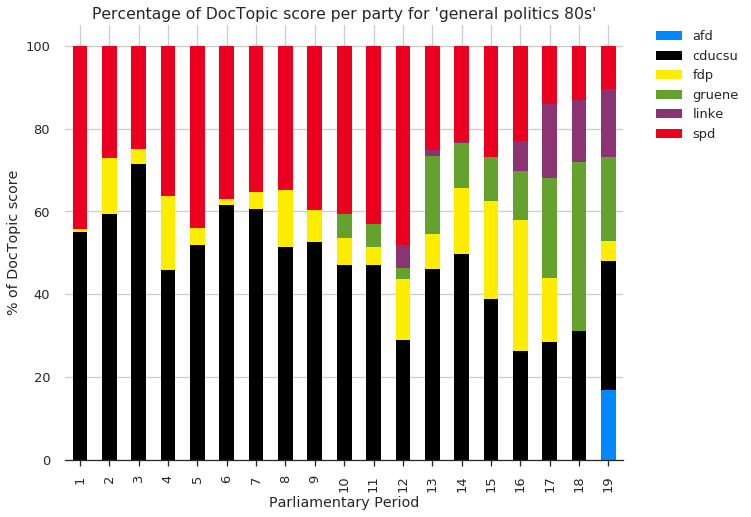

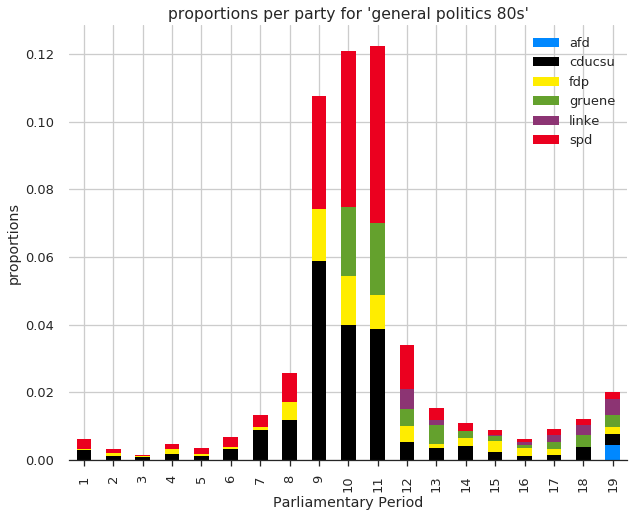

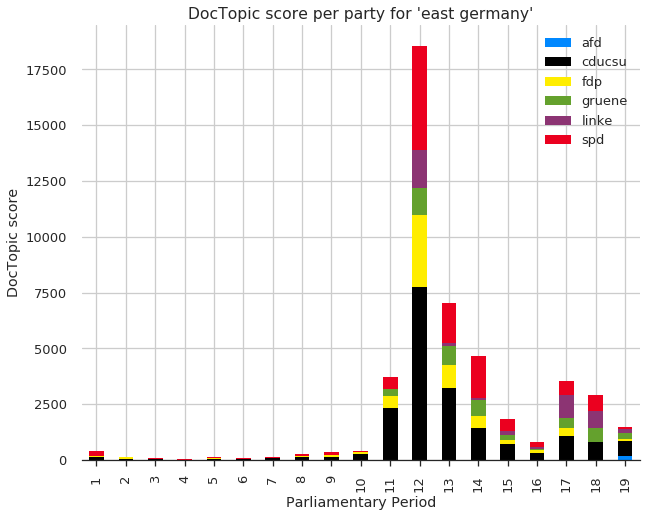

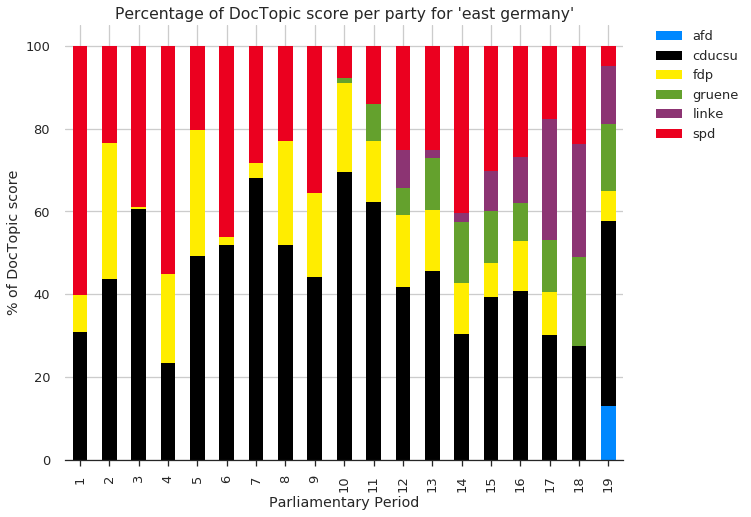

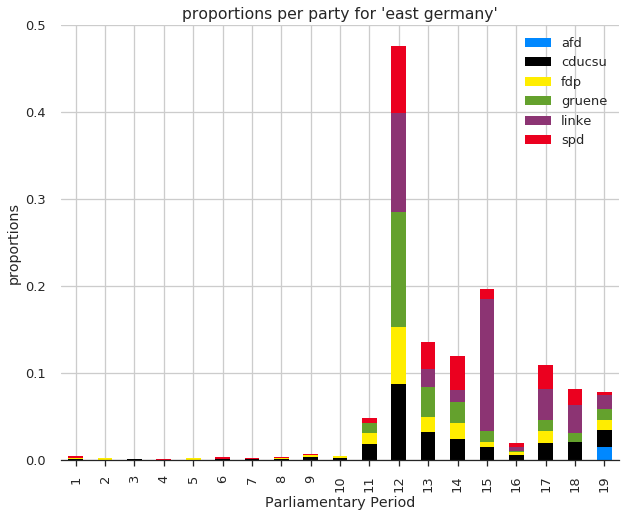

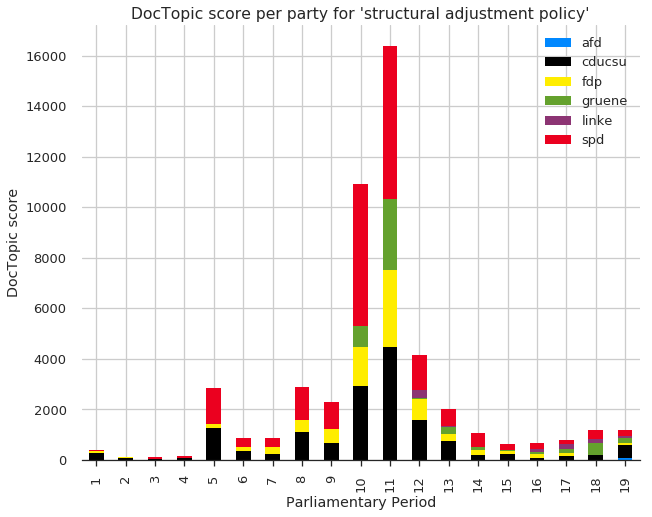

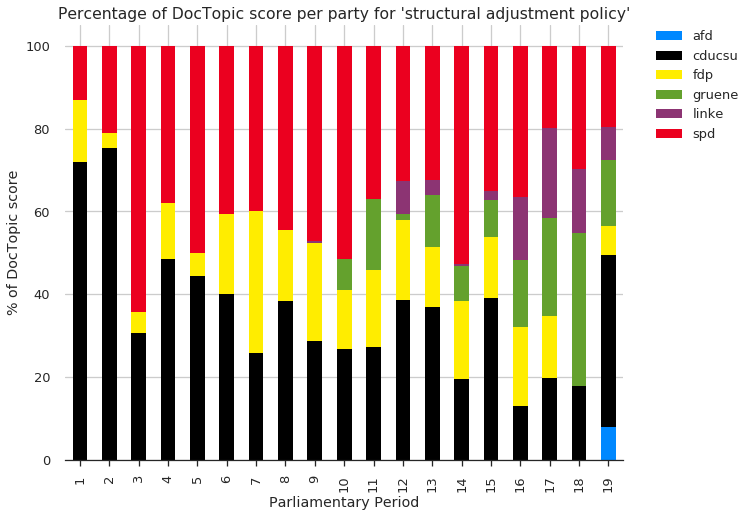

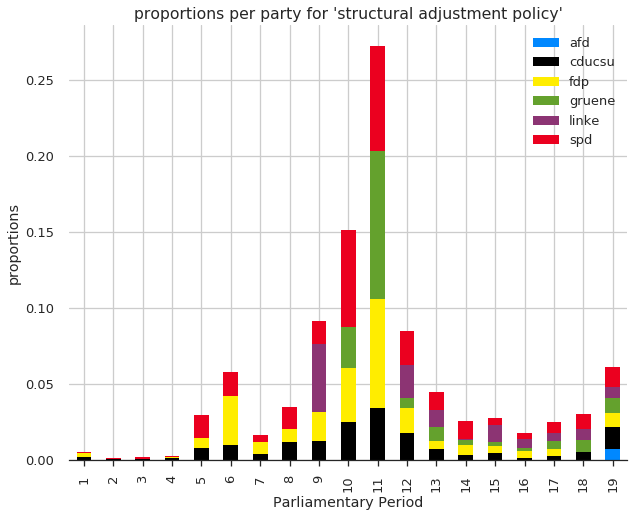

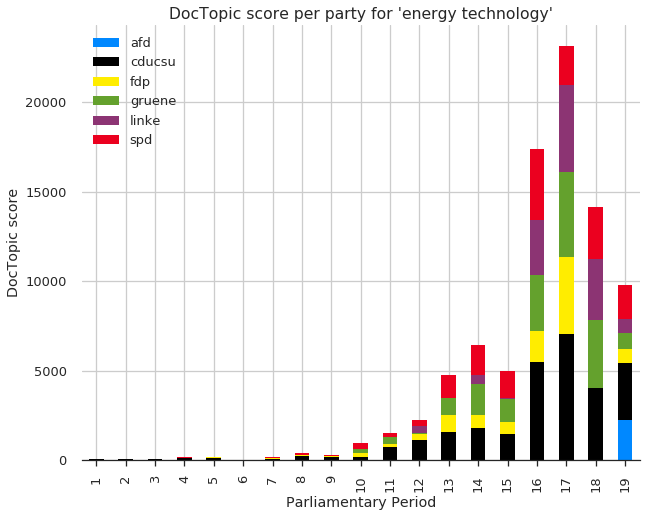

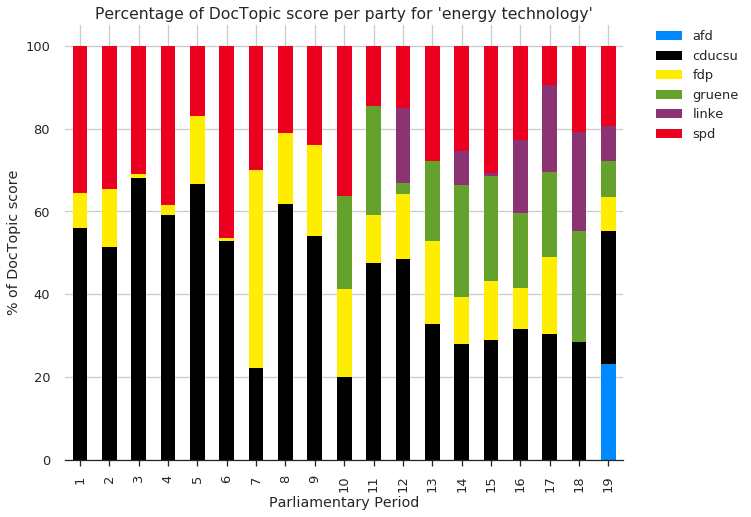

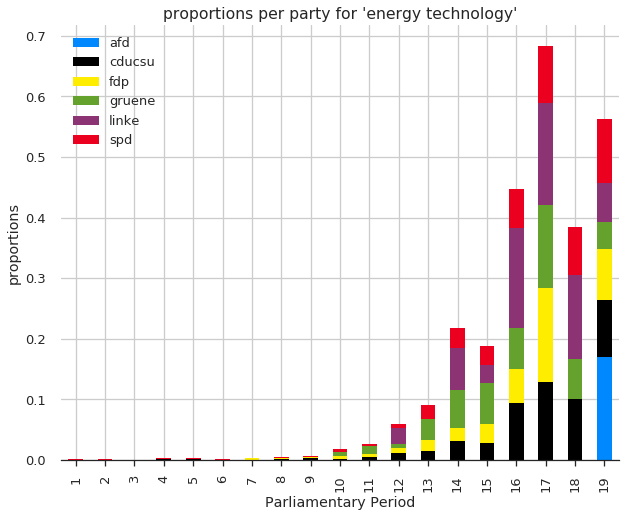

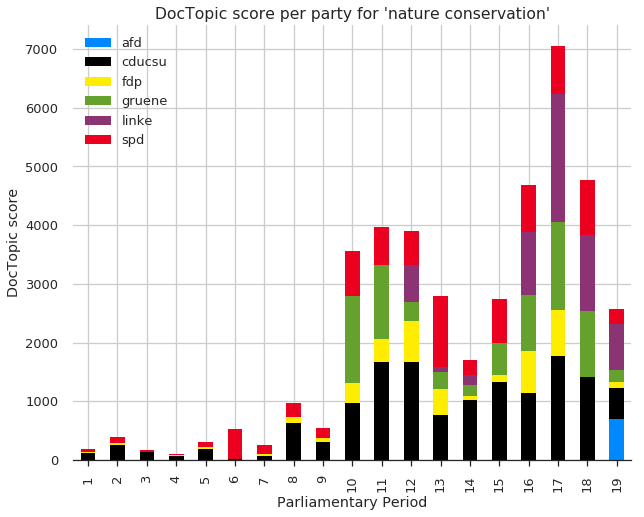

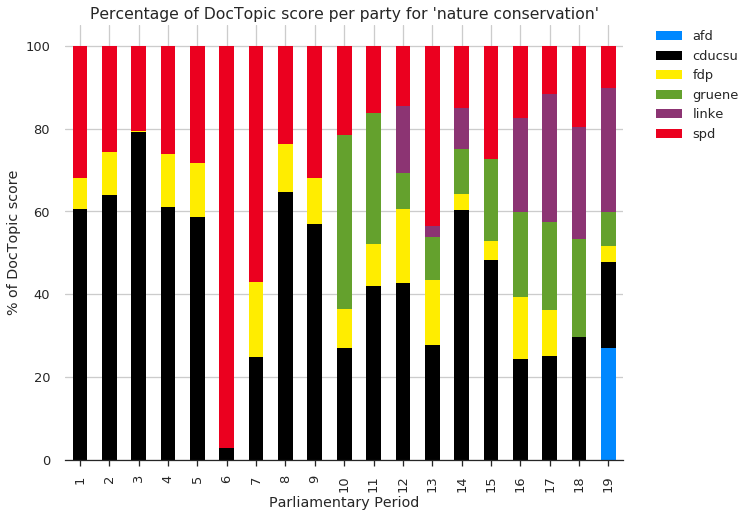

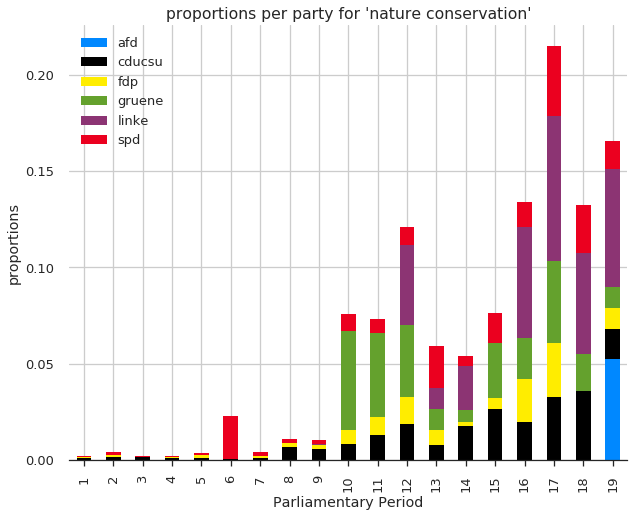

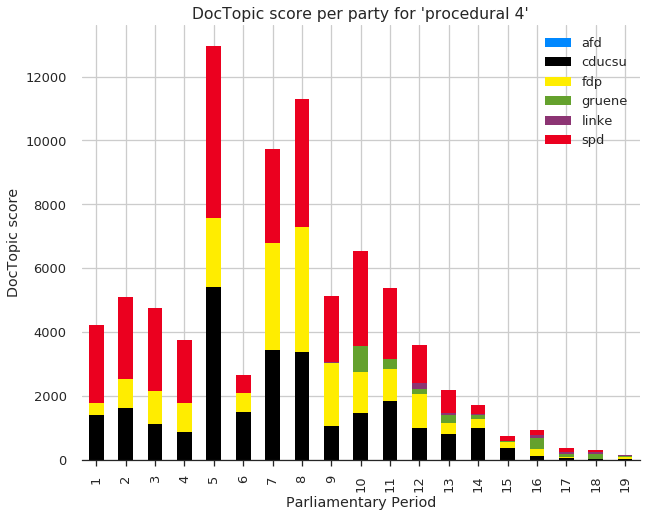

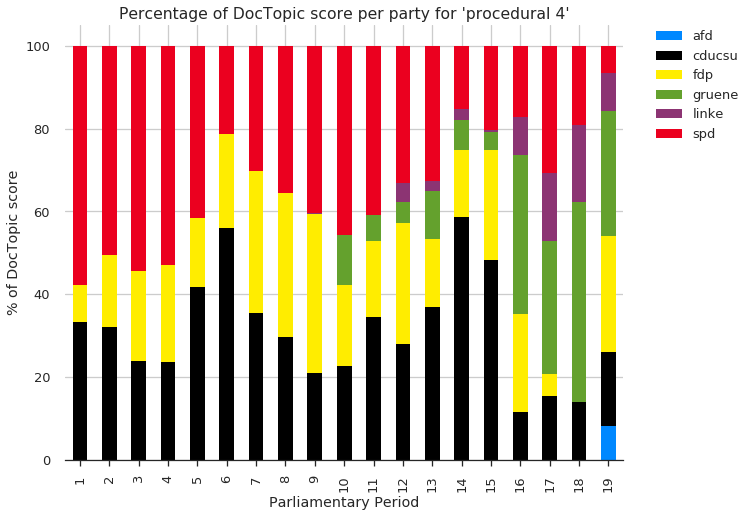

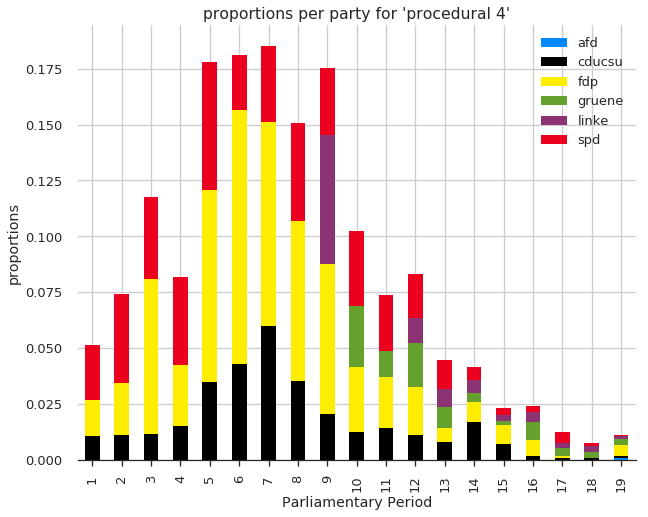

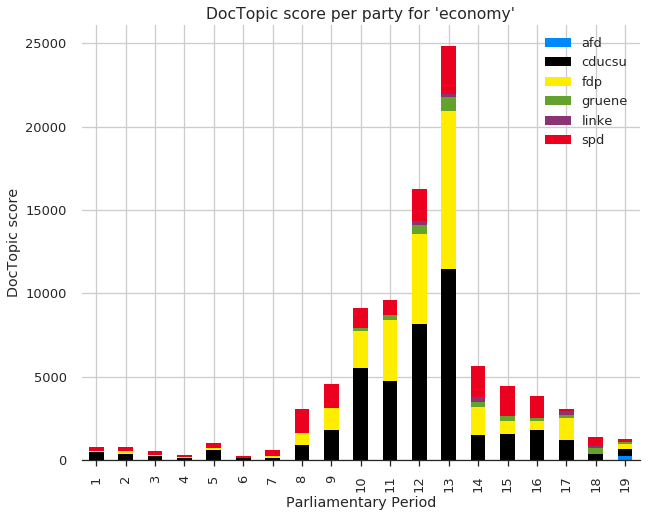

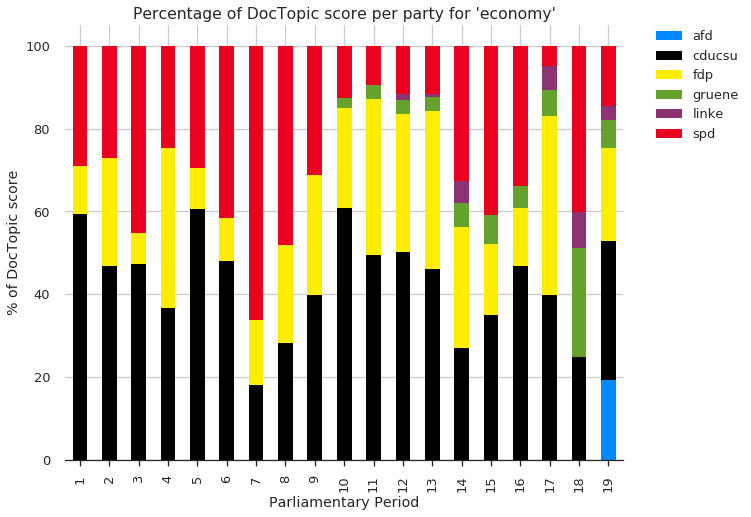

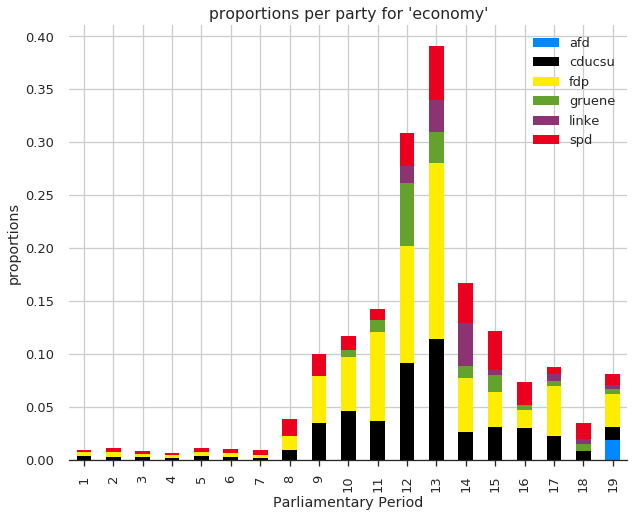

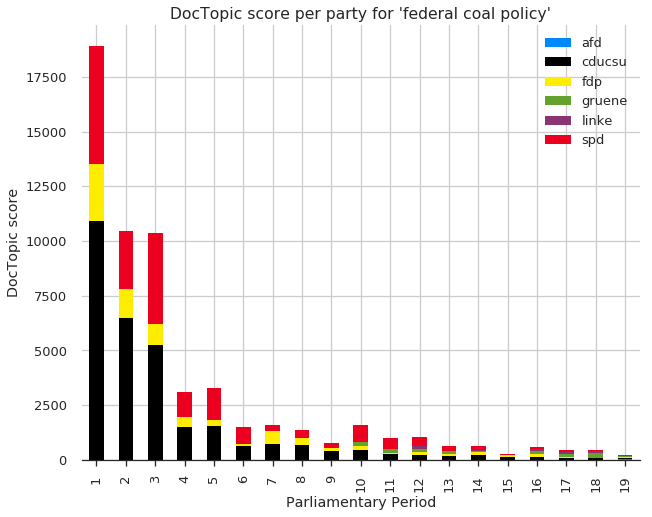

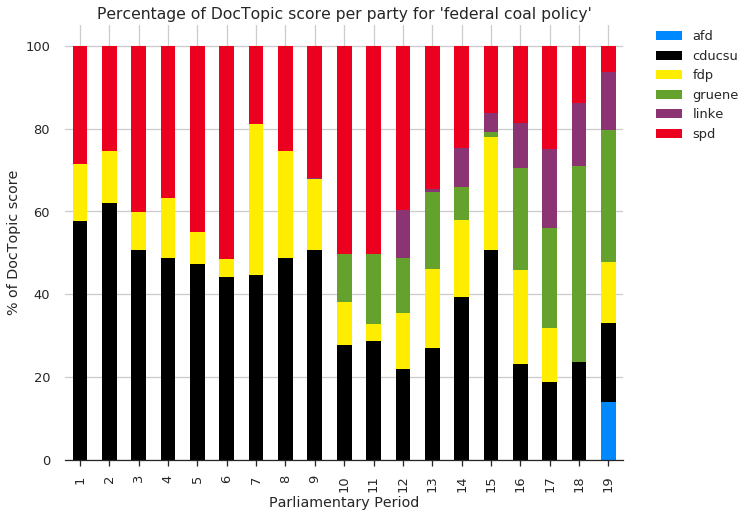

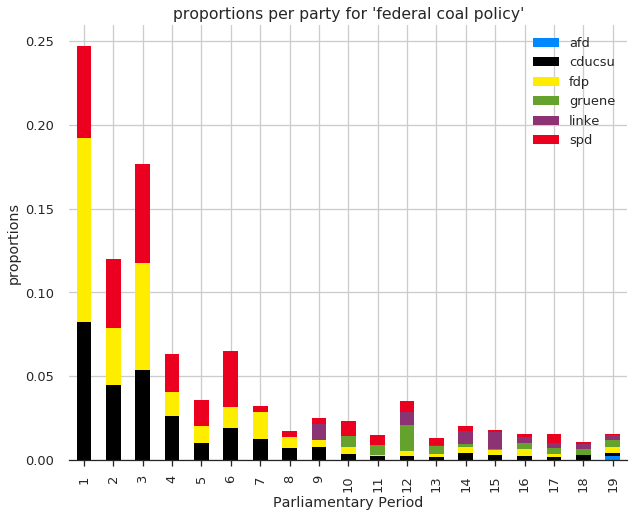

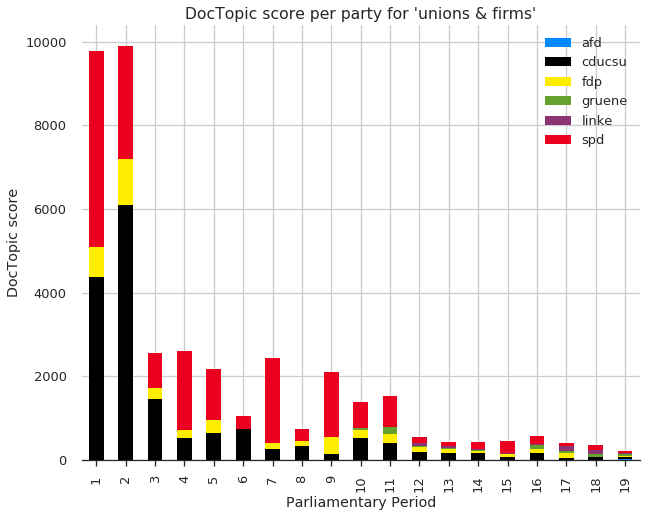

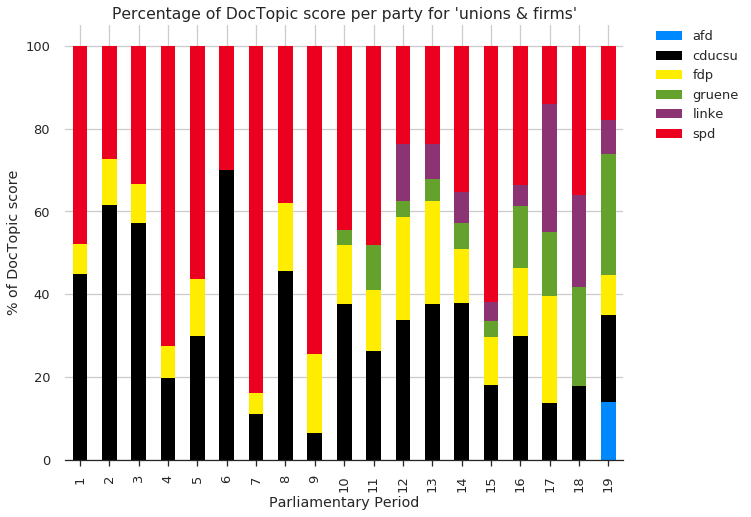

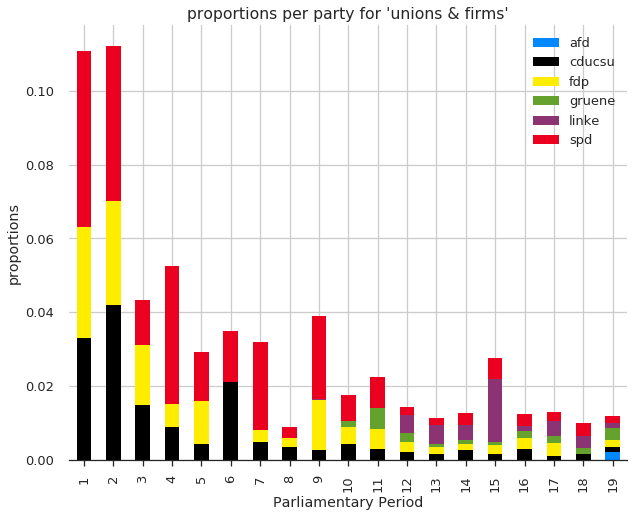

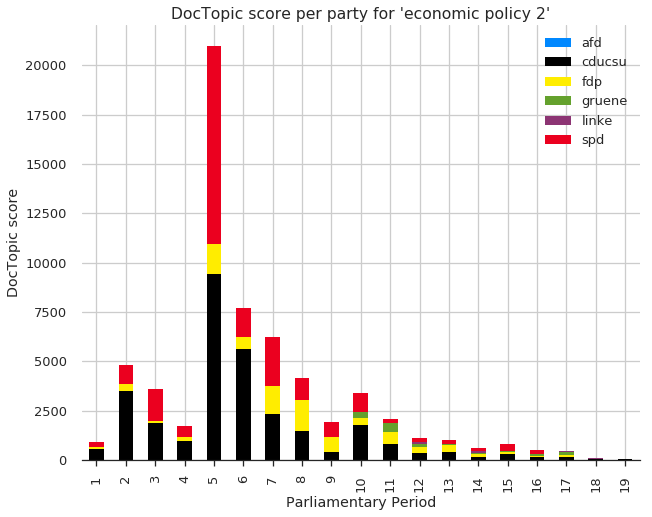

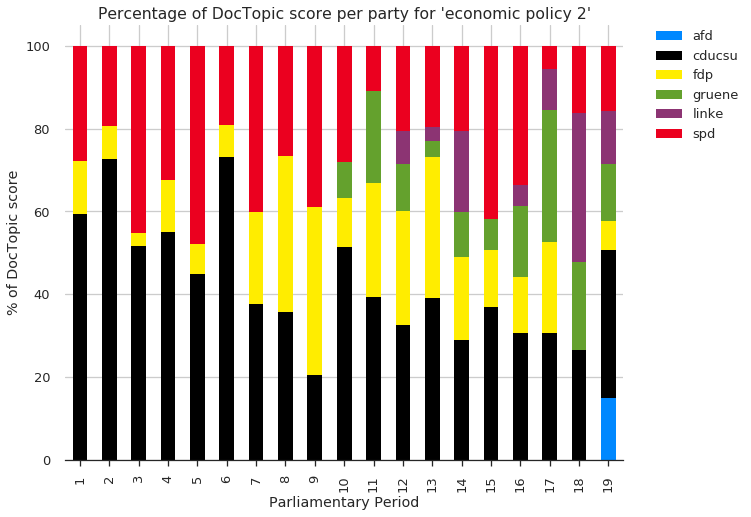

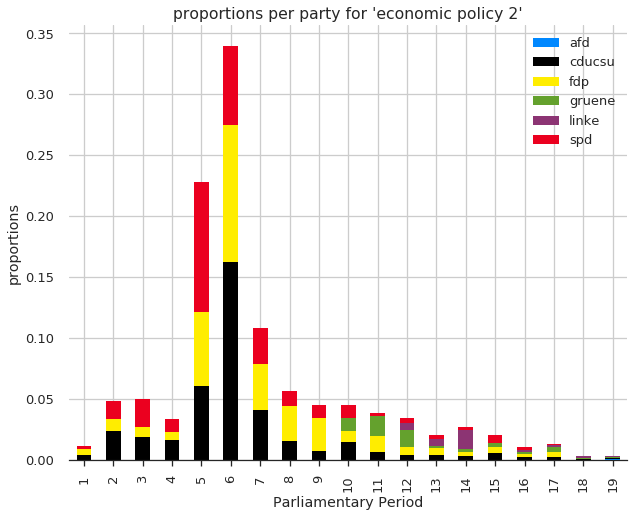

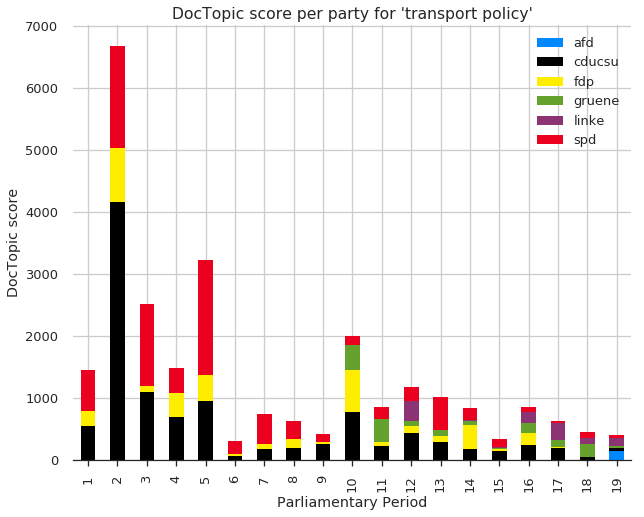

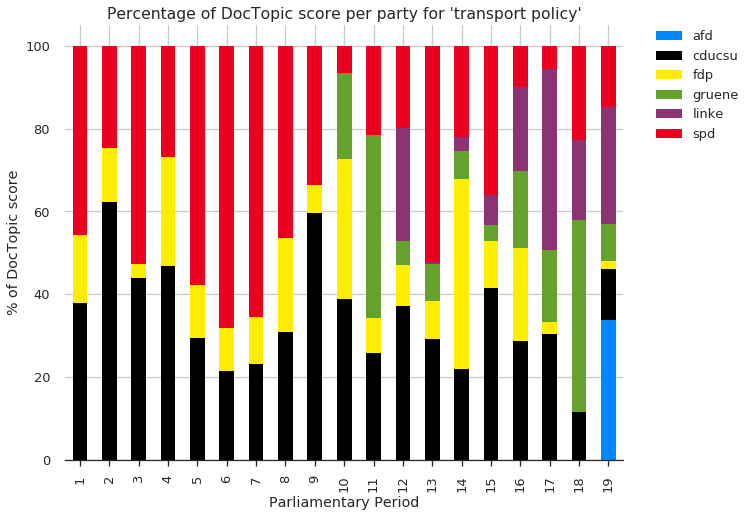

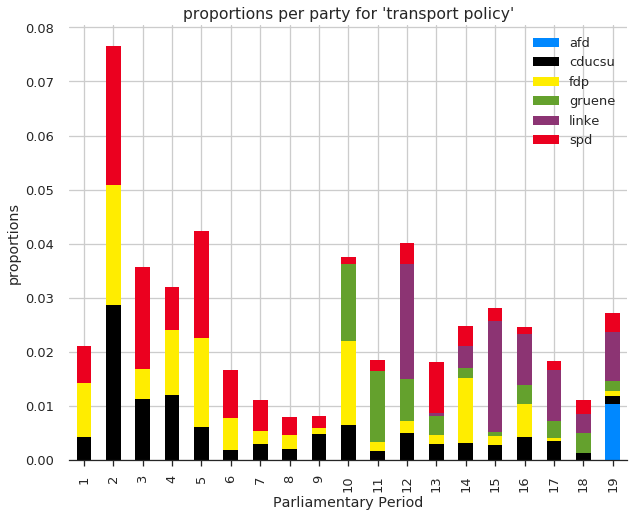

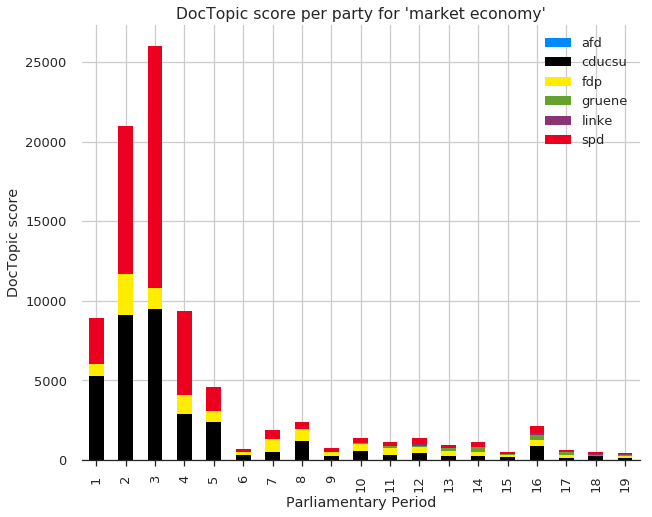

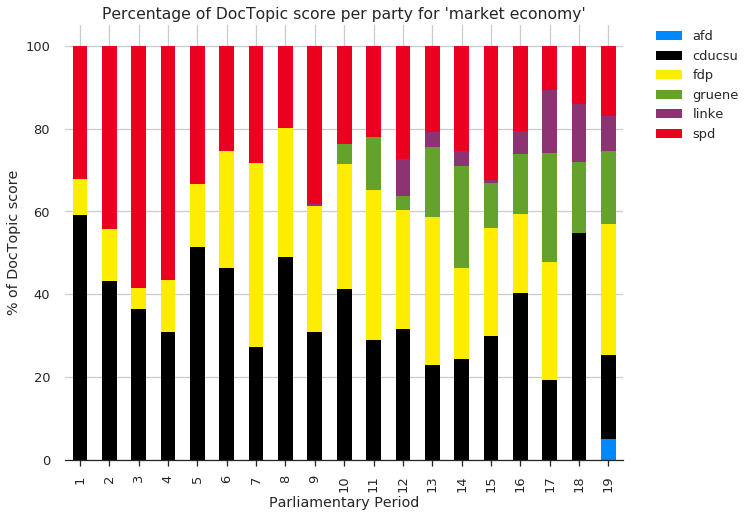

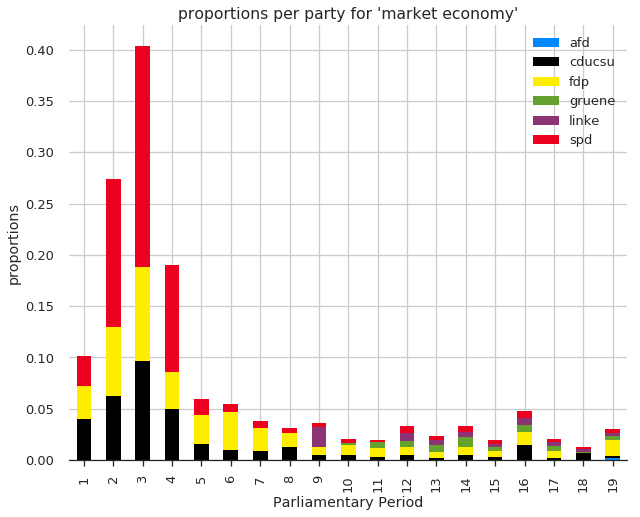

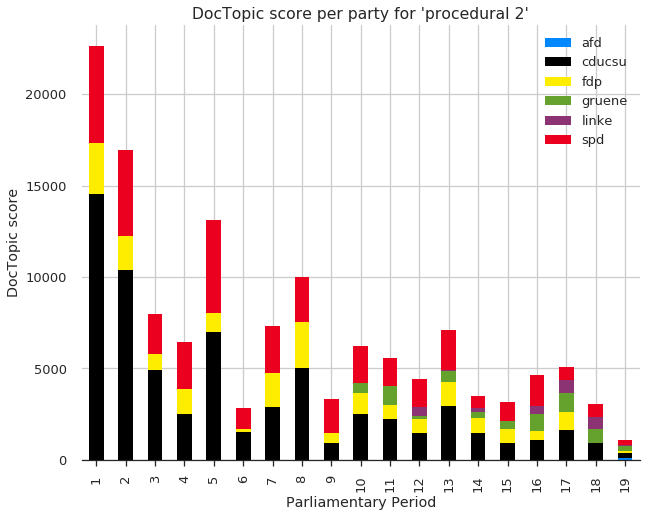

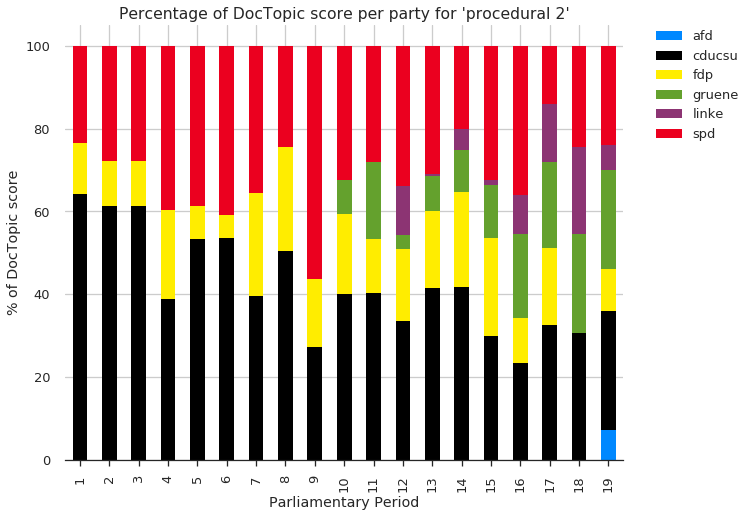

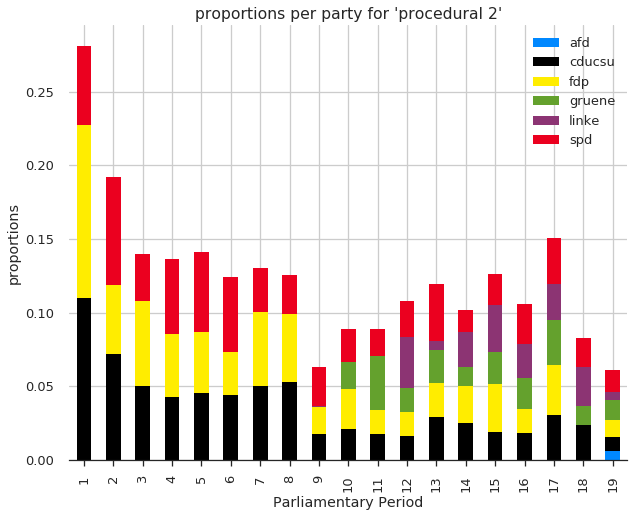

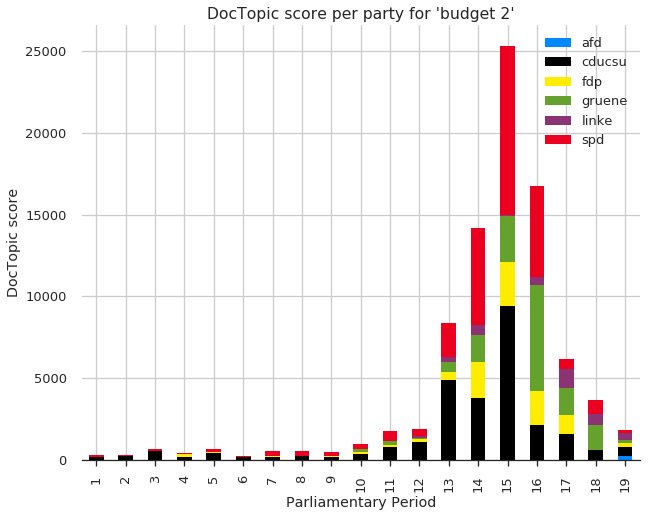

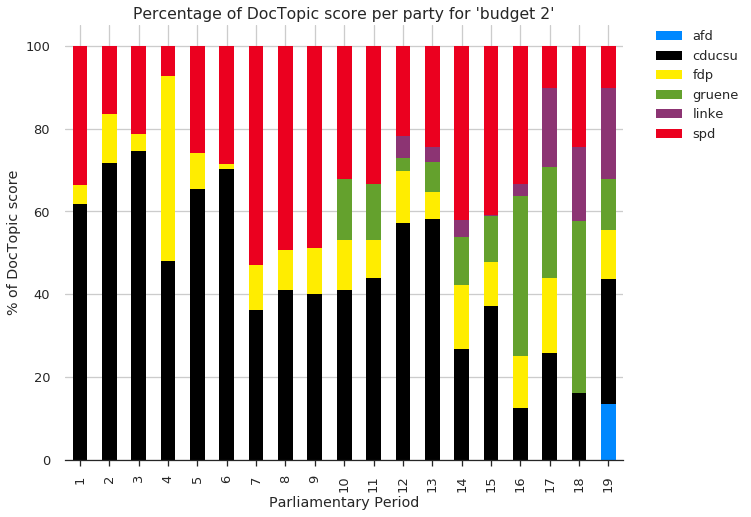

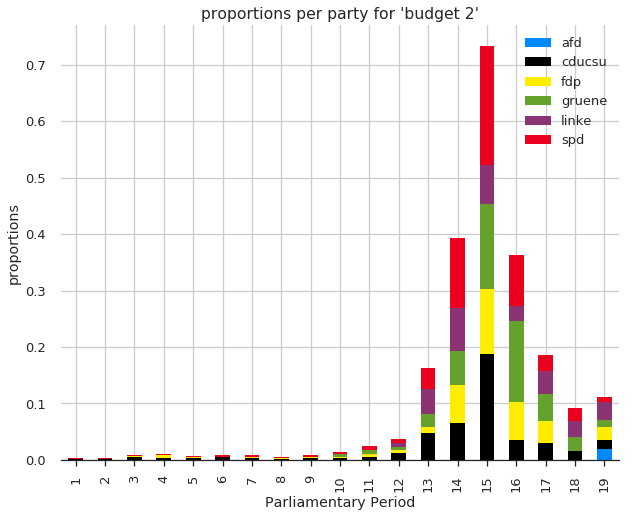

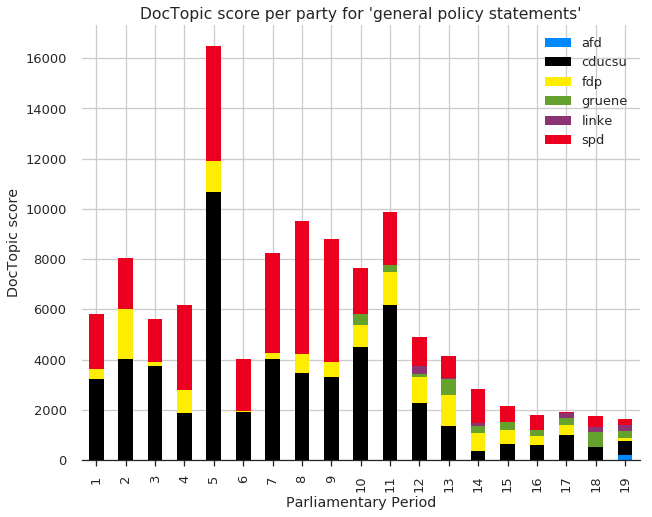

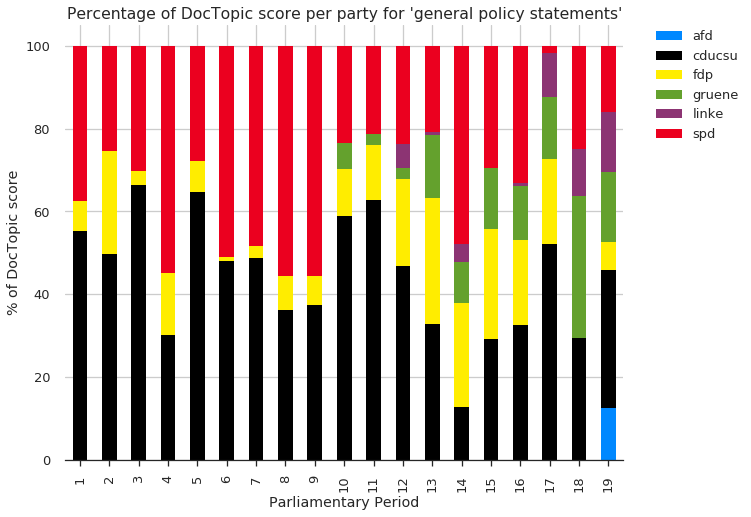

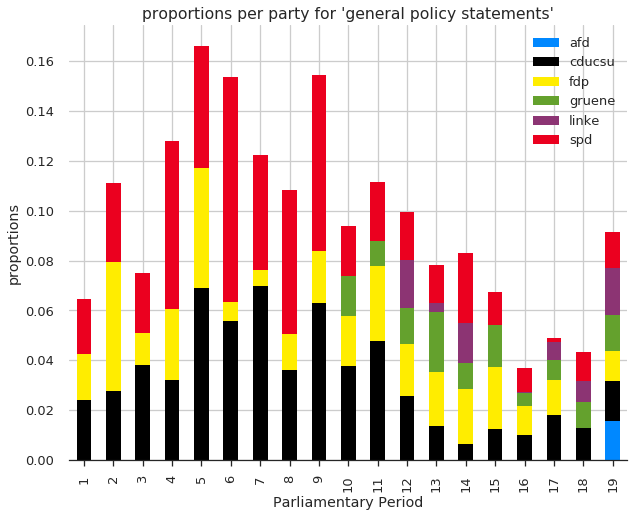

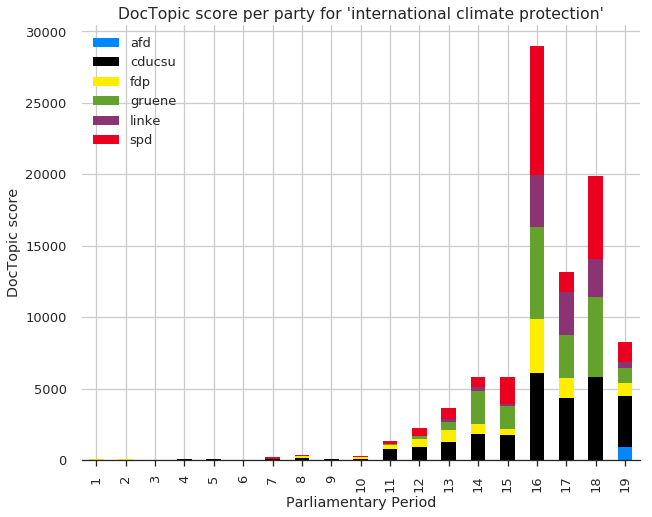

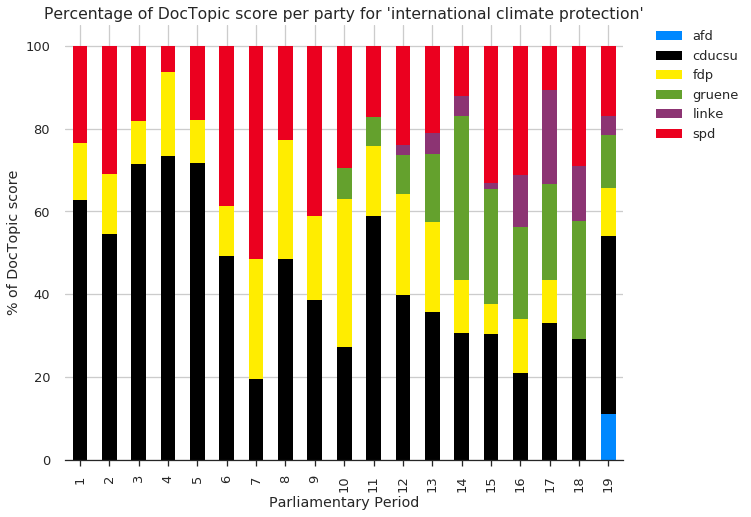

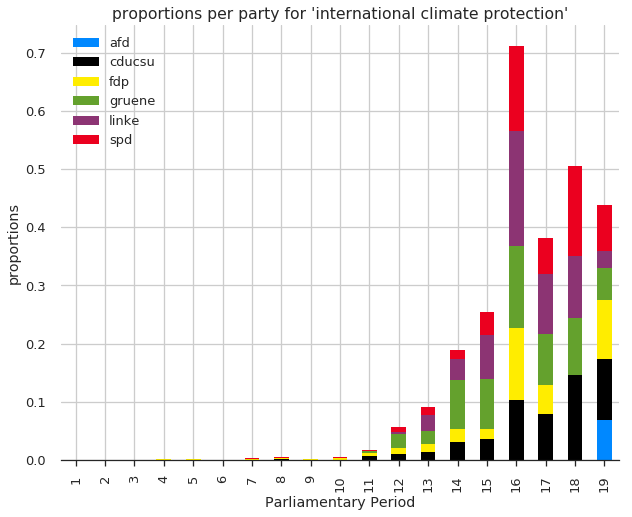

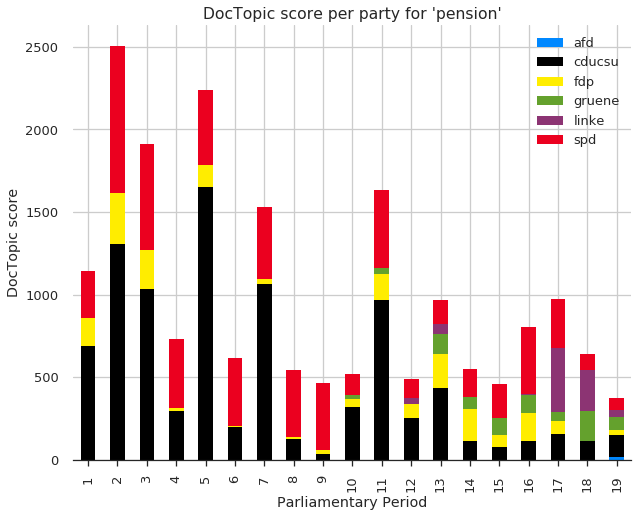

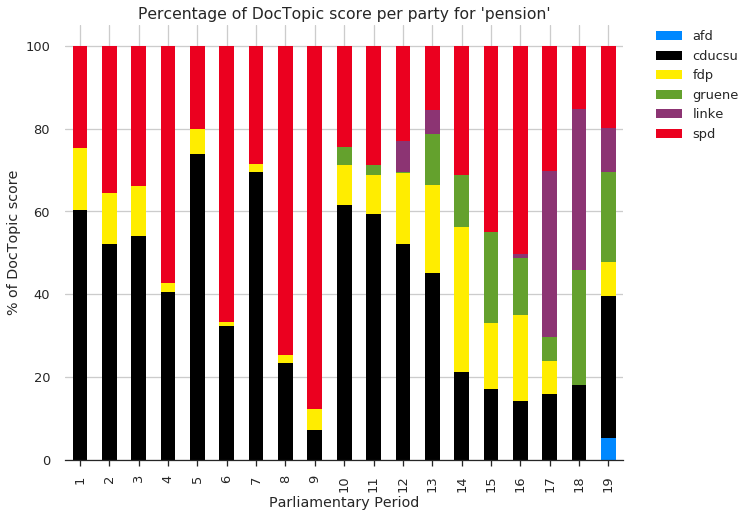

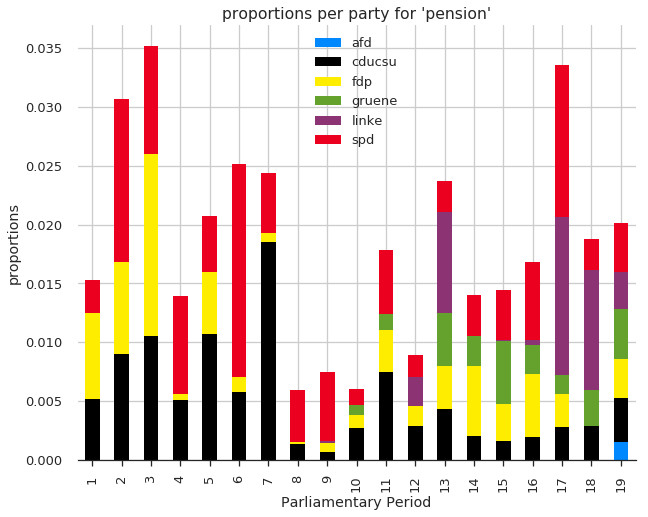

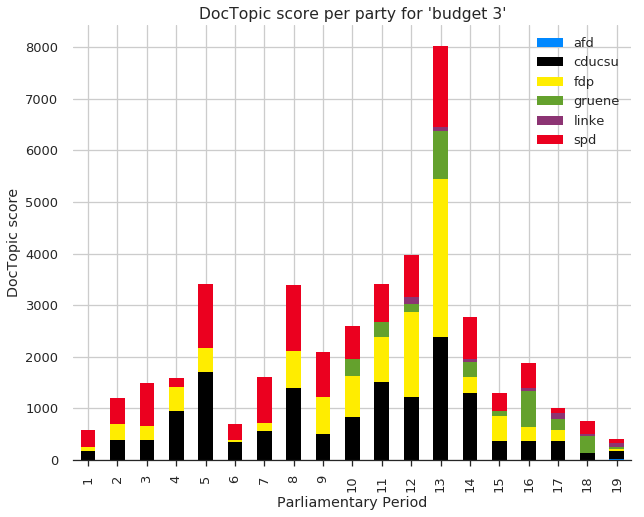

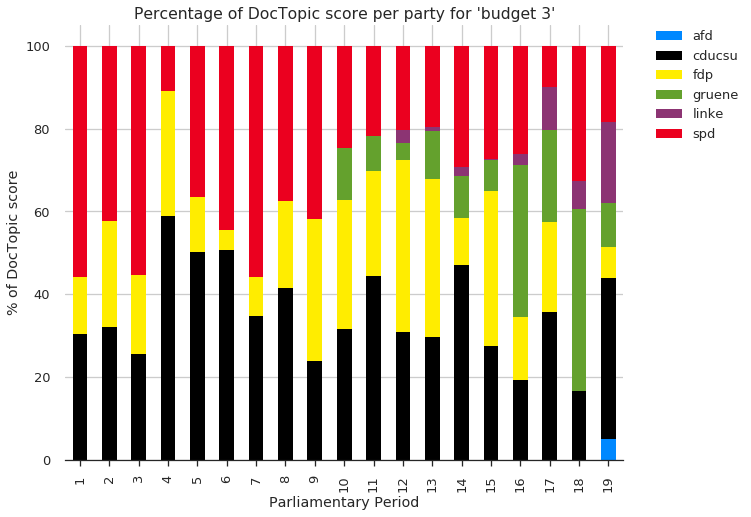

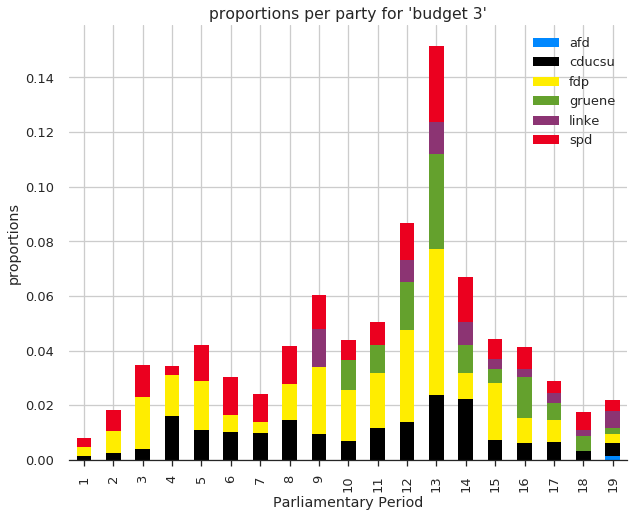

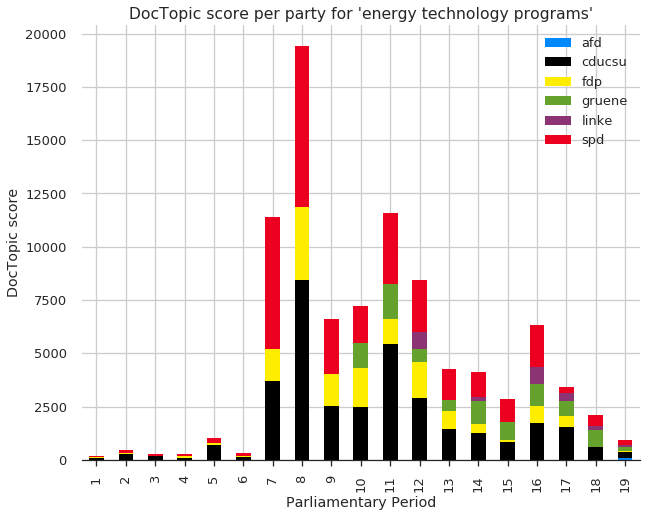

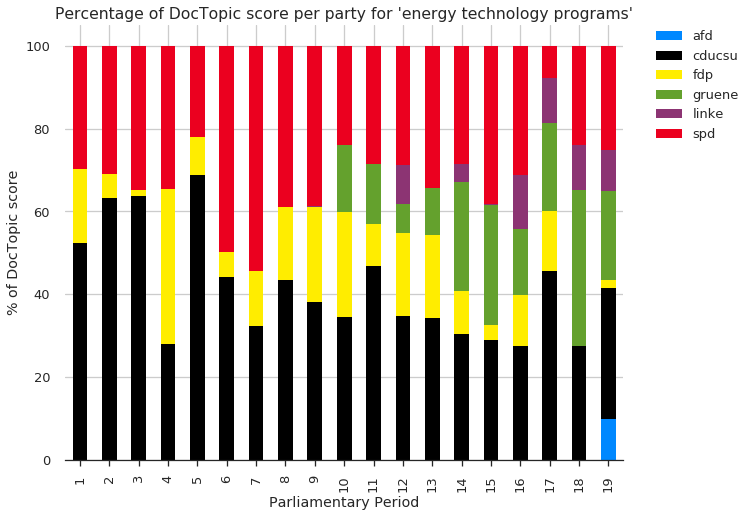

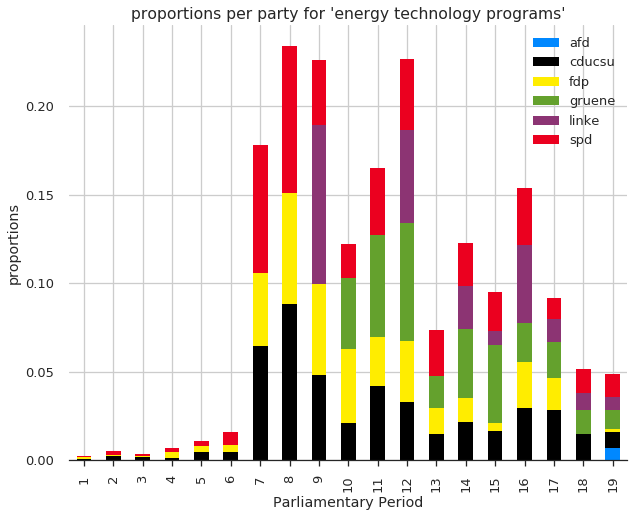

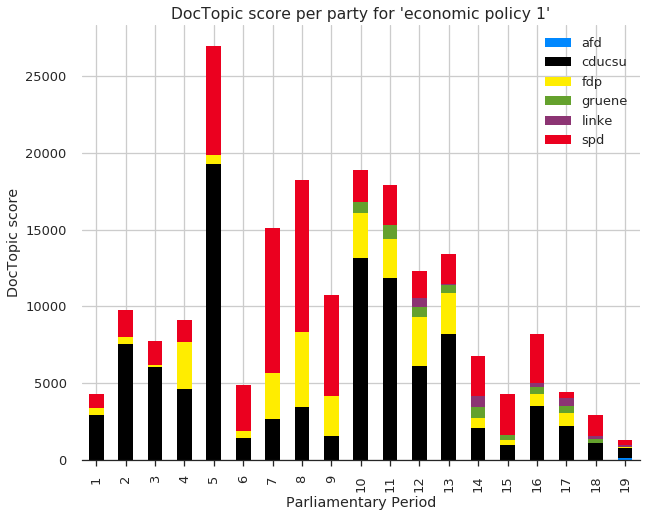

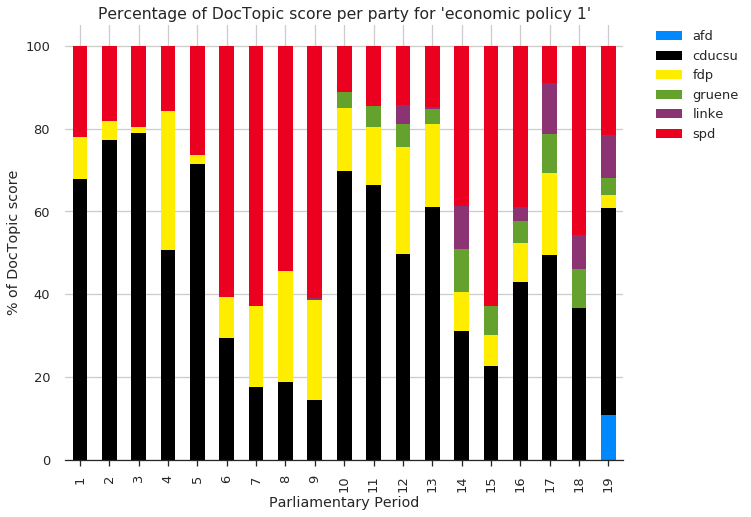

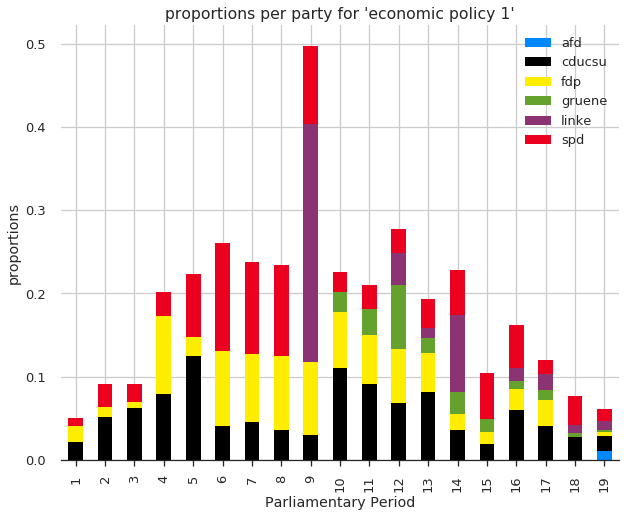

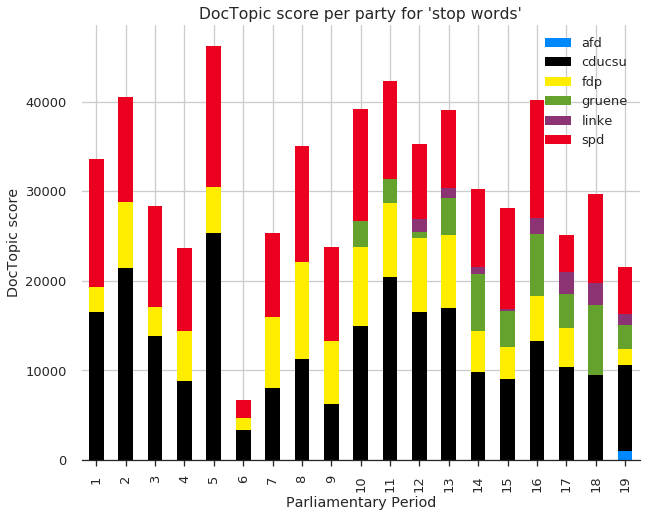

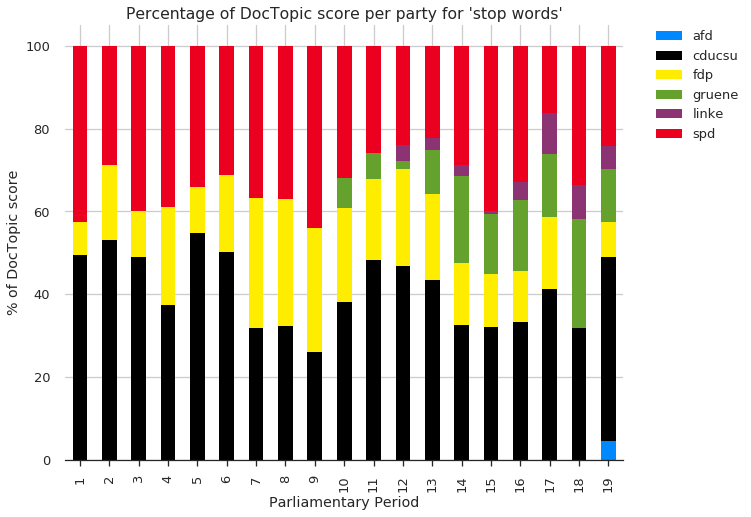

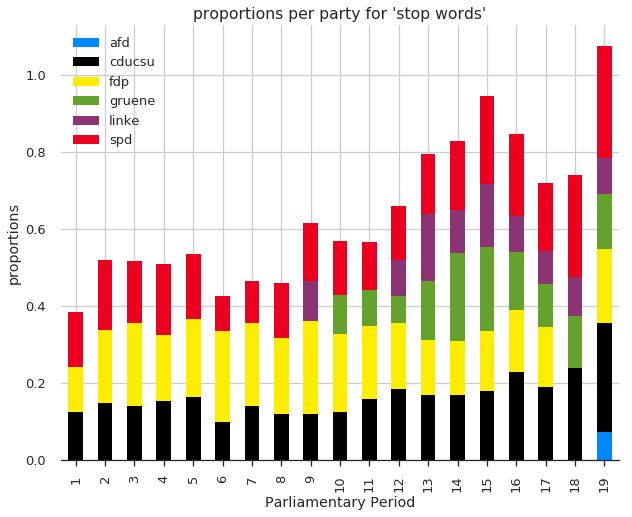

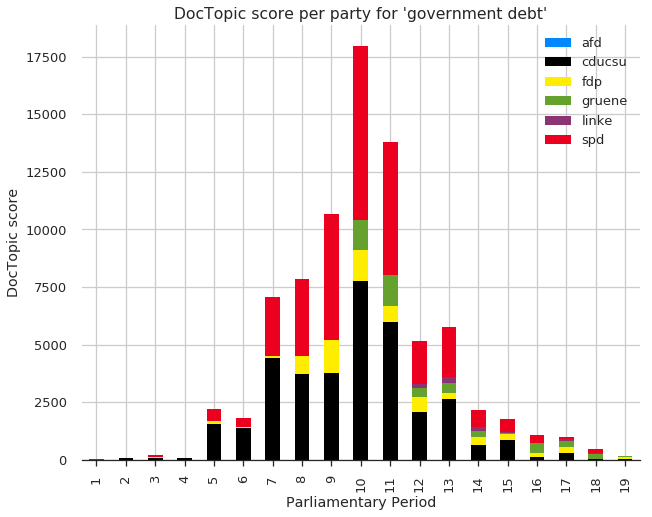

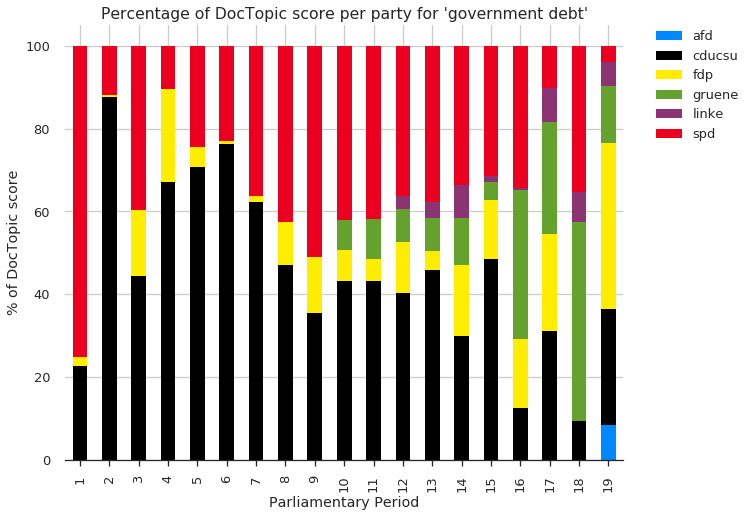

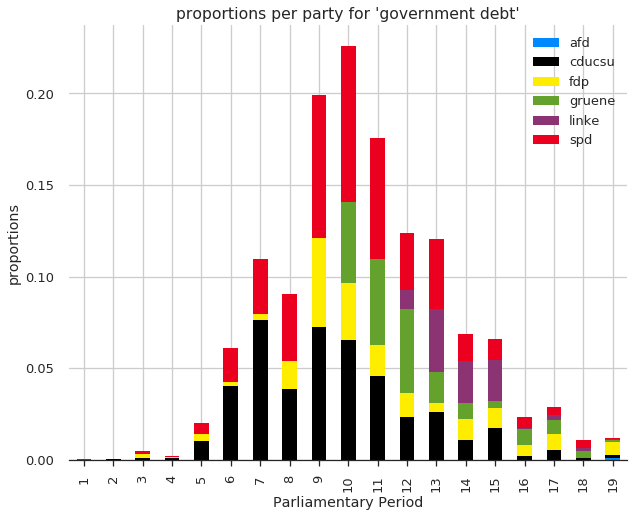

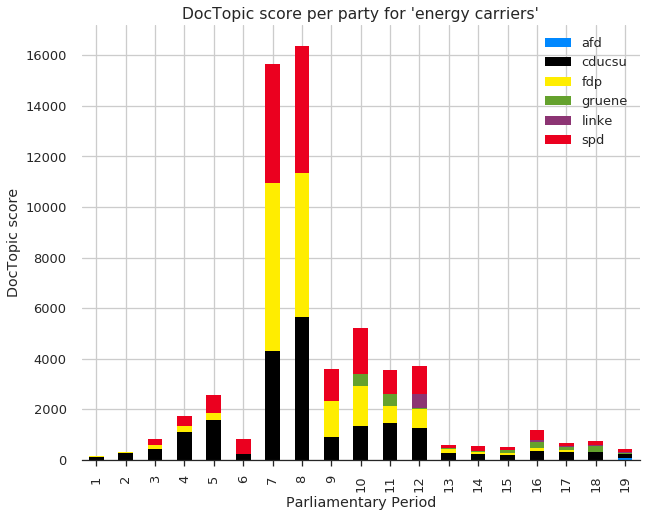

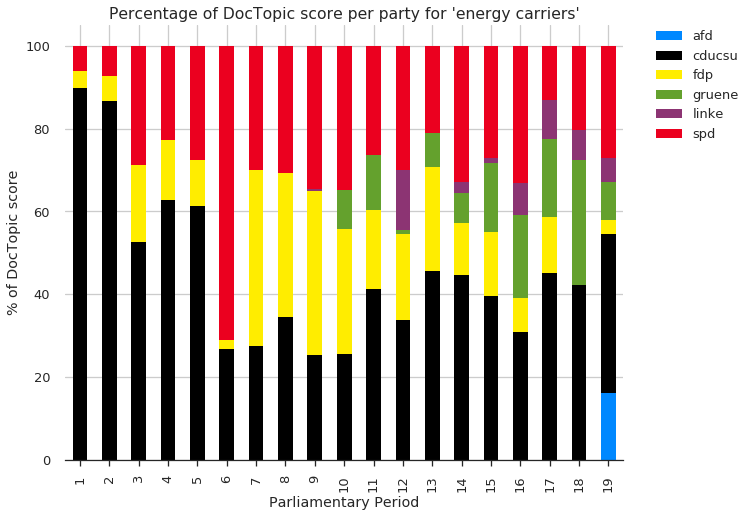

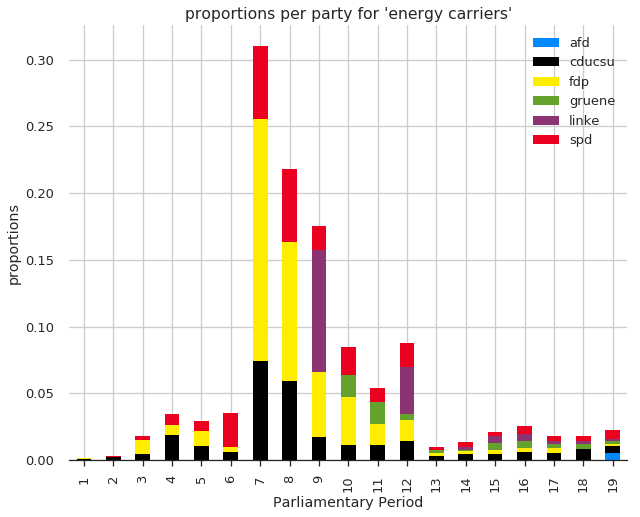

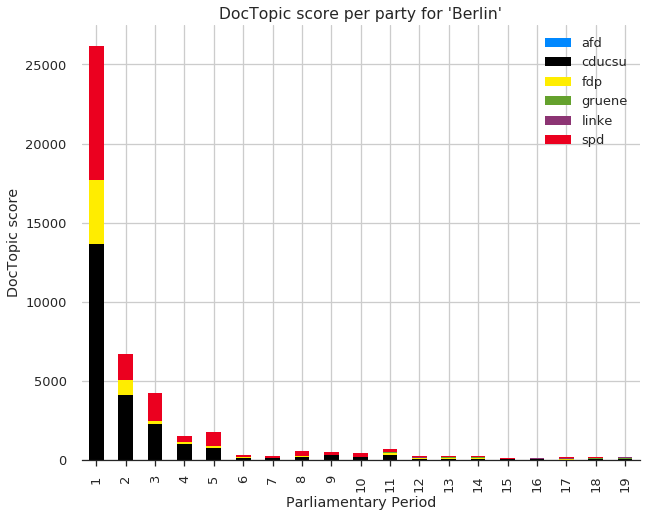

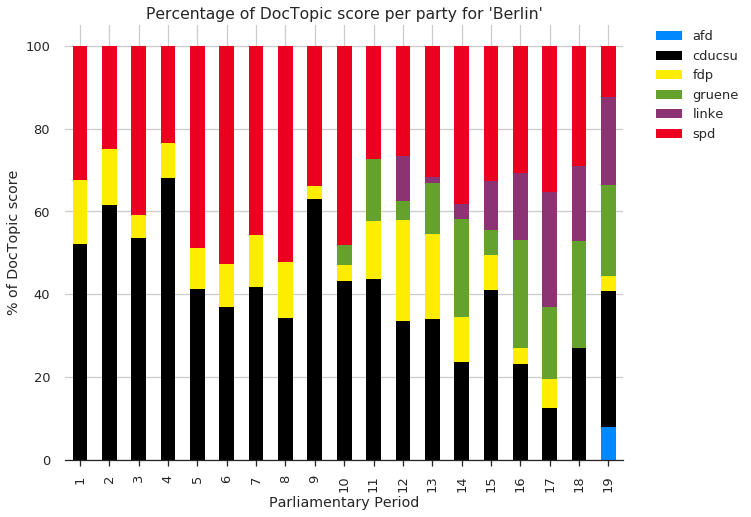

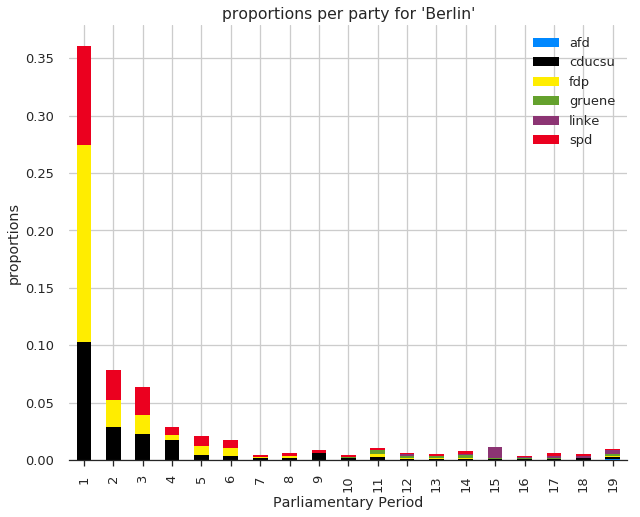

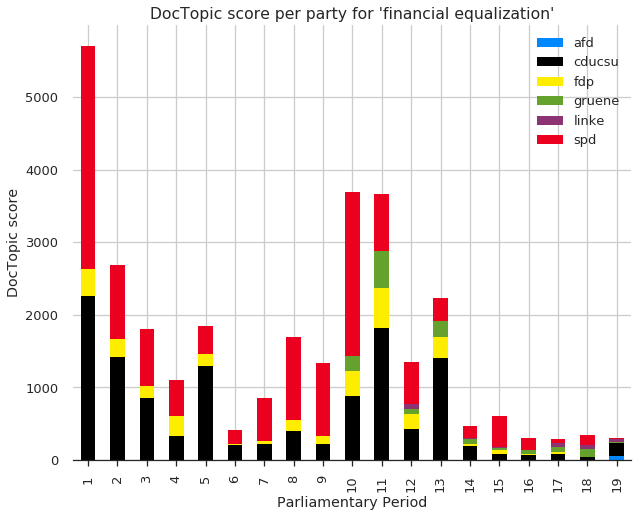

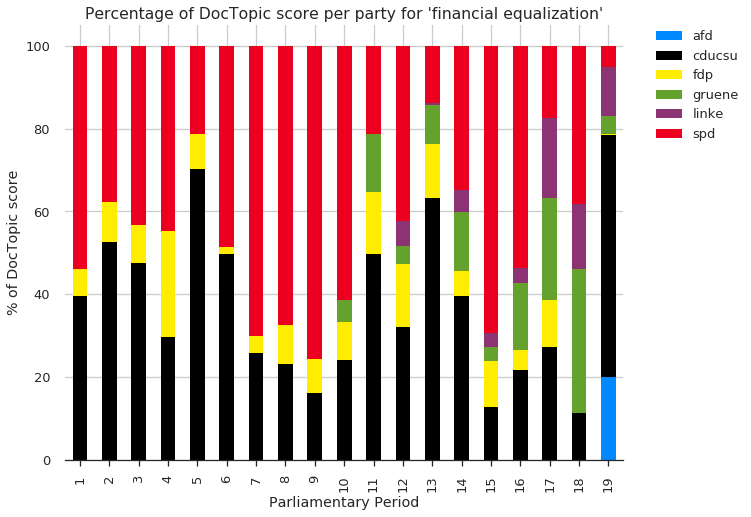

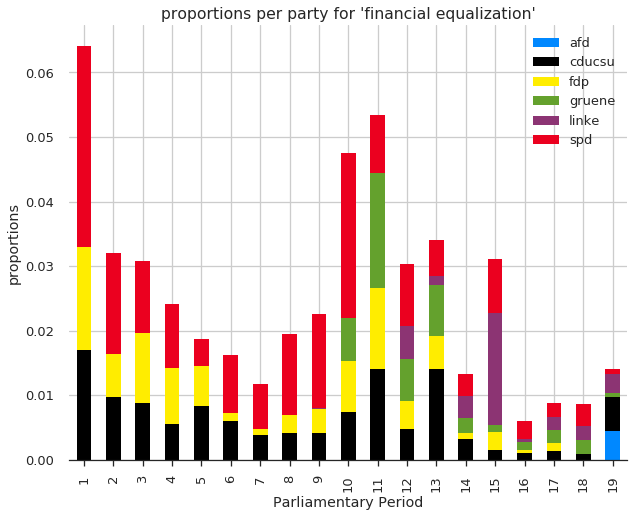

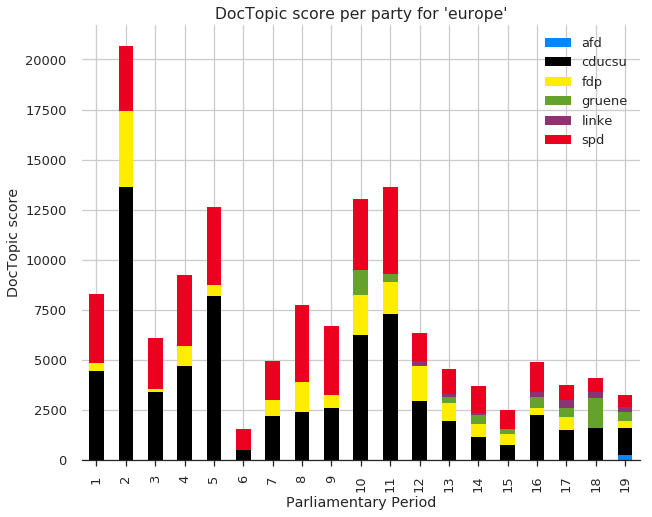

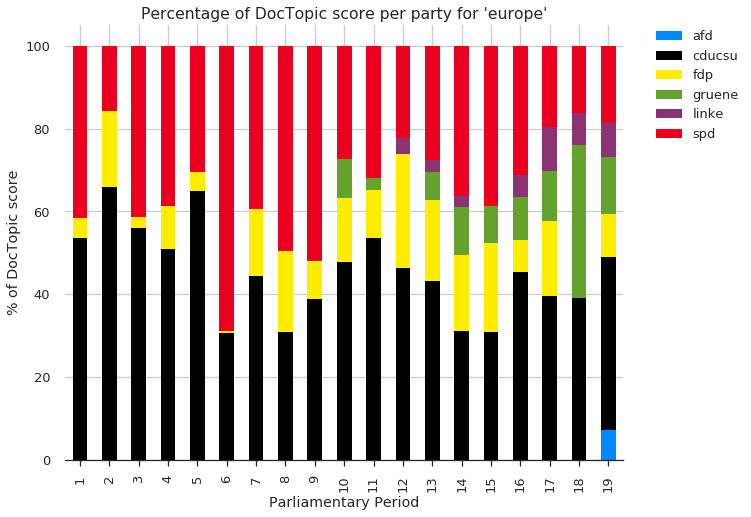

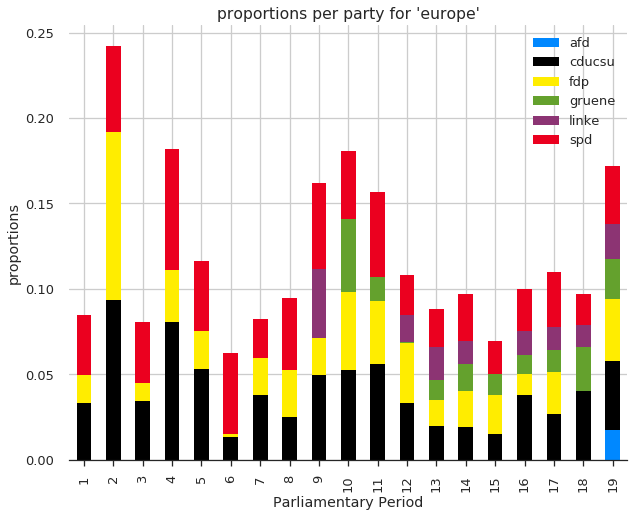

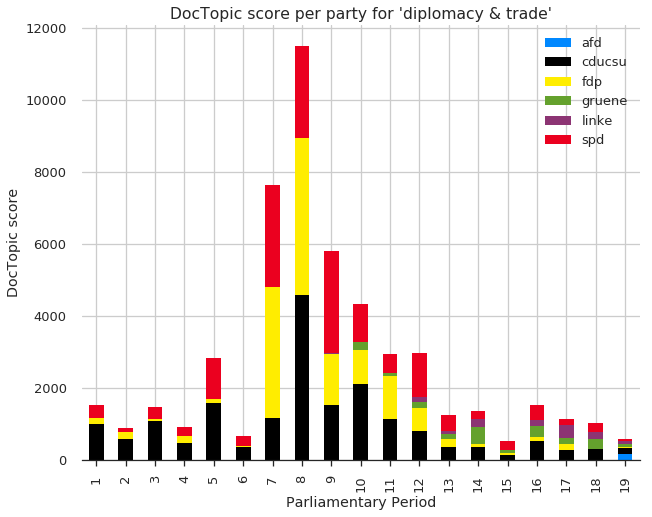

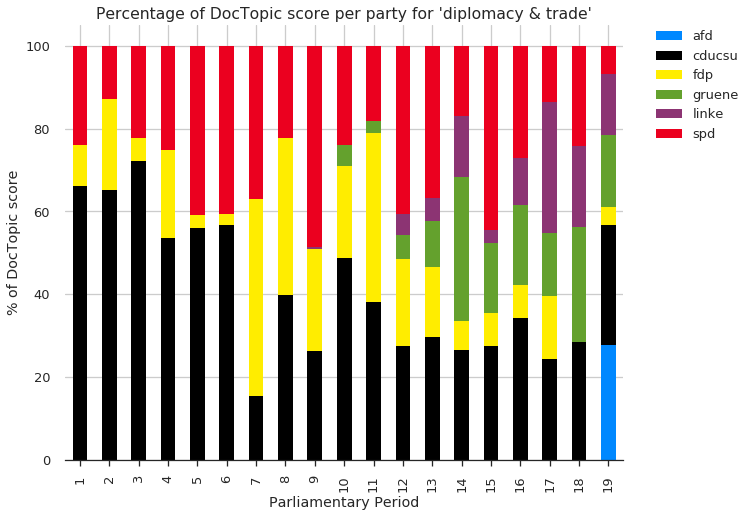

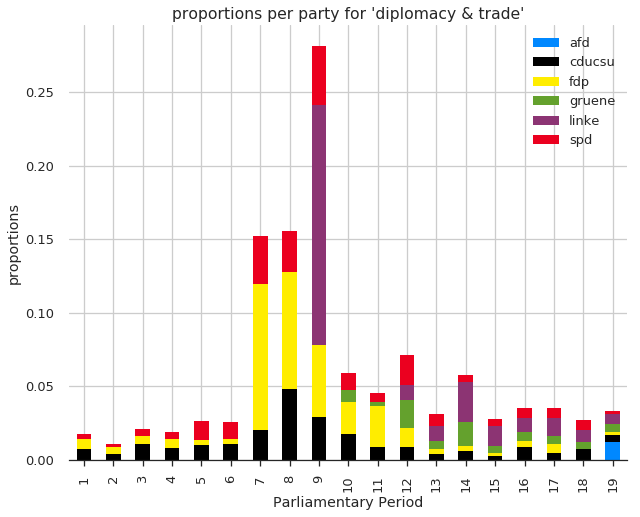

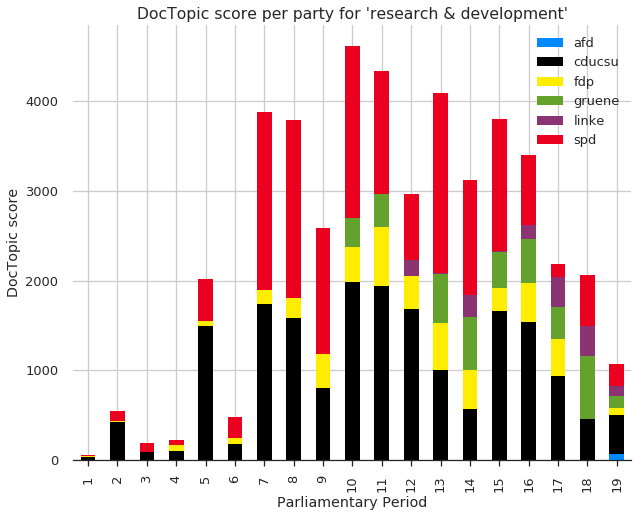

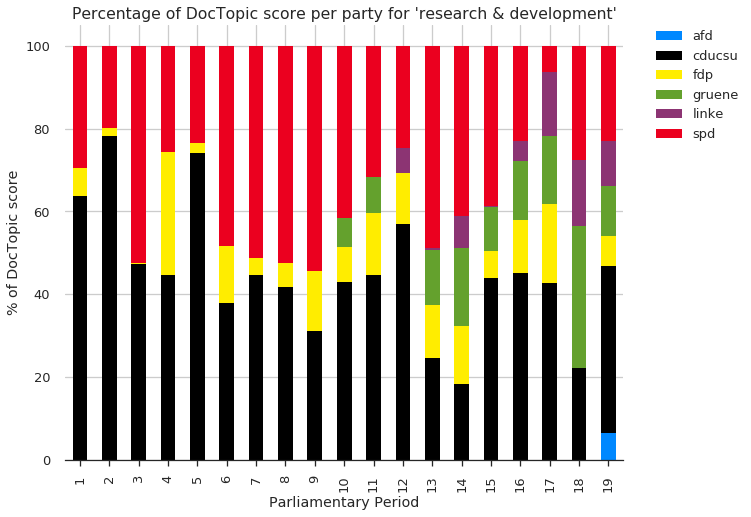

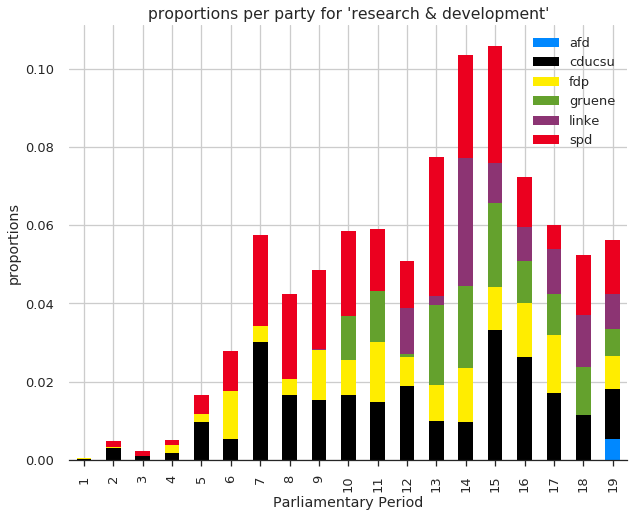

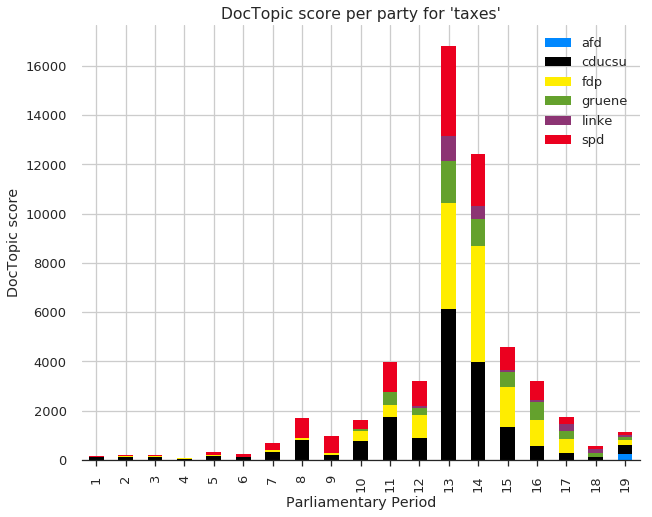

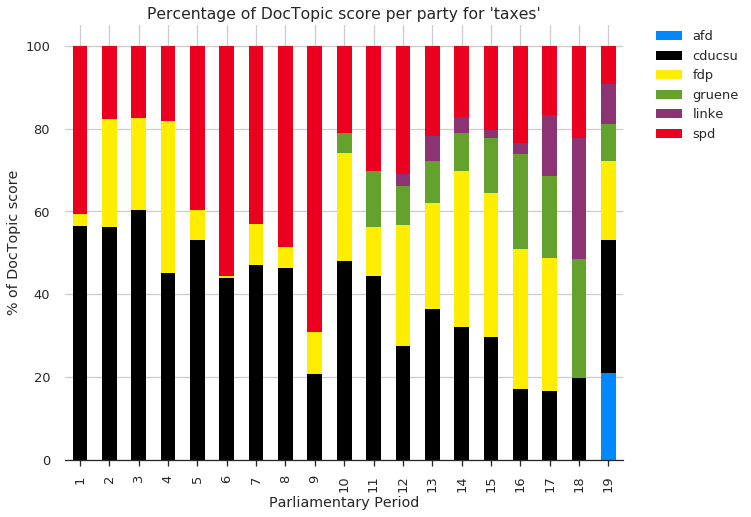

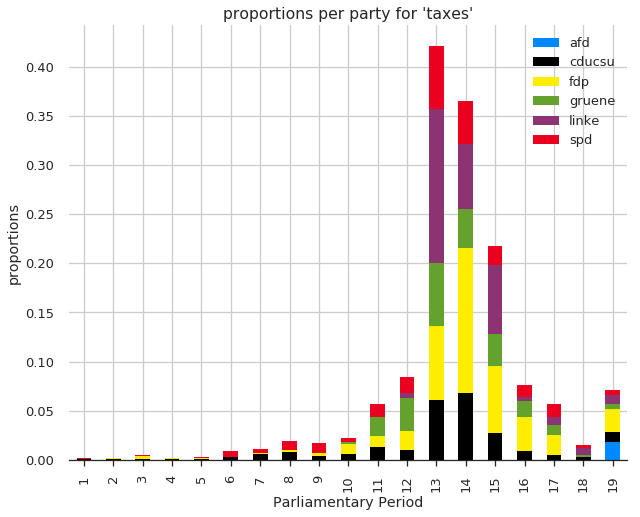

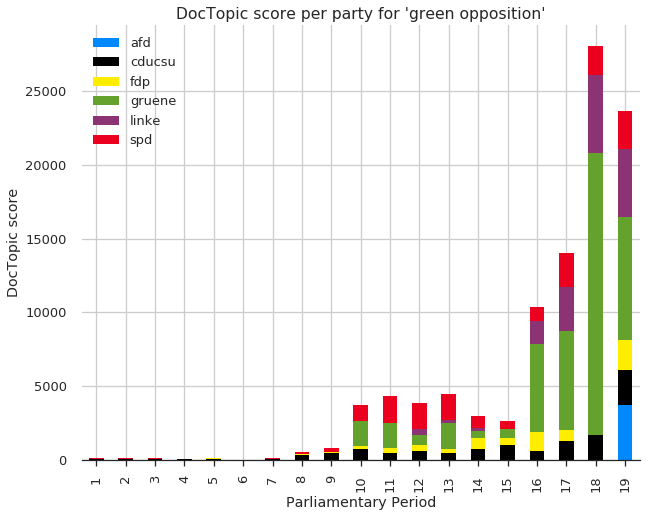

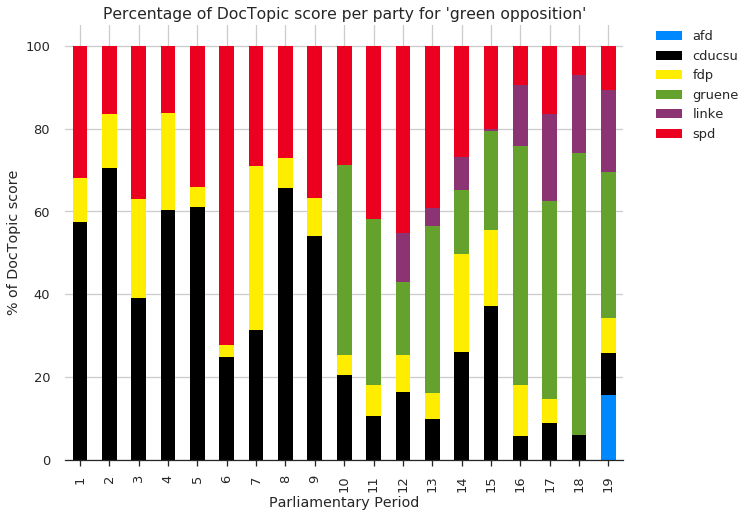

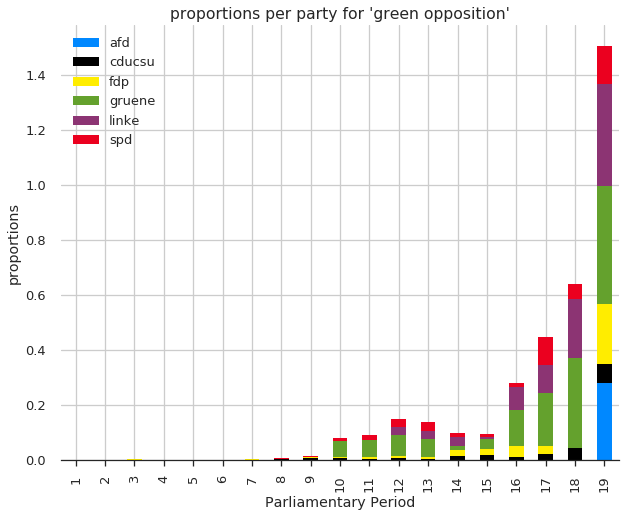

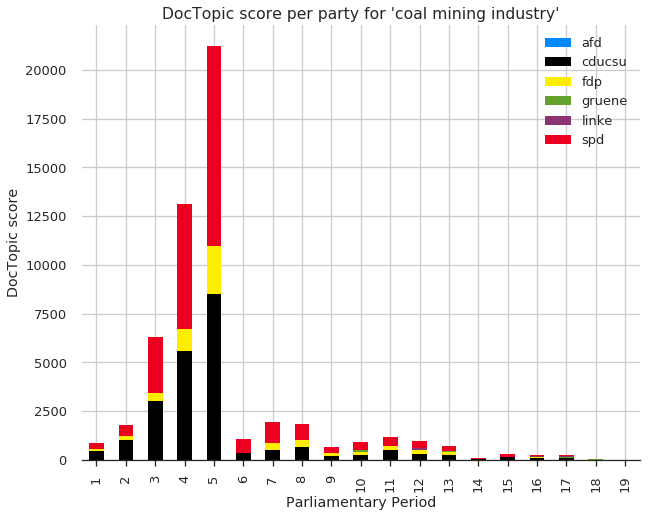

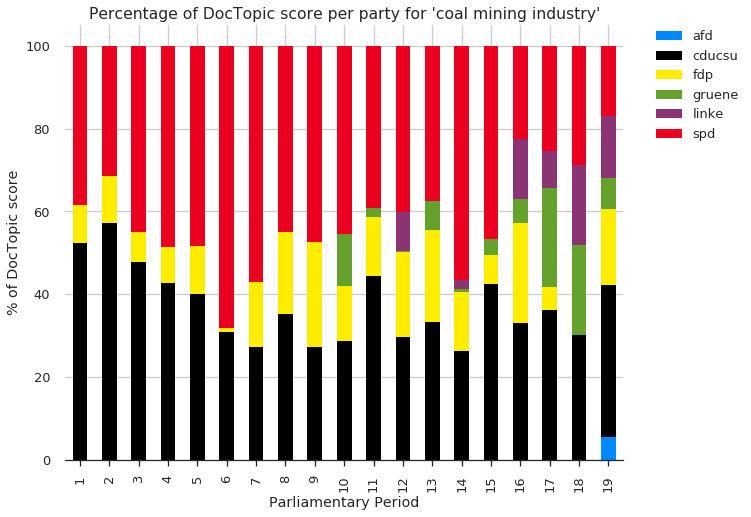

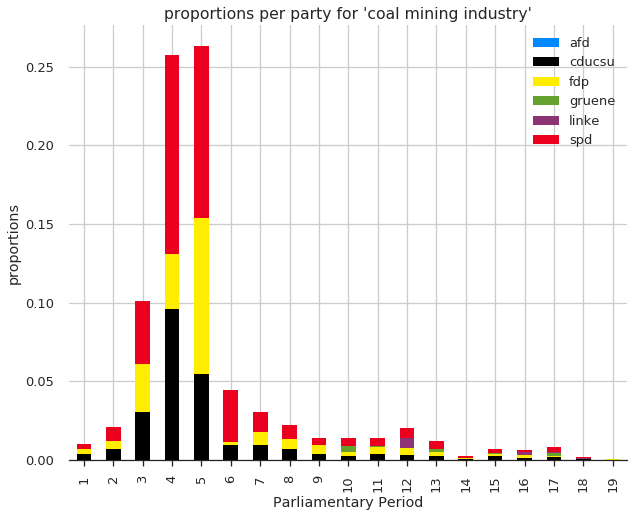

In [13]:
# for ISIE talk:
#topic_id = 167089 # climate policy
#topic_id = 167076 # economy and jobs

topics = Topic.objects.filter(run_id=run_id)

for topic in topics:
    df_scores, df_proportions = get_table_for_party_plots(topic.id)
    topic_label = topic.title
    stacked_bar_plot_party(df_scores, topic_label, filename=os.path.join(save_dir, 'party_scores_run_{}_topic_{}.png'.format(run_id, topic.id)))
    #stacked_bar_plot_party(df_scores, topic_label, pct=True, filename=os.path.join(save_dir, 'party_scores_pct_run_{}_topic_{}.png'.format(run_id, topic.id)))
    stacked_bar_plot_party(df_proportions, topic_label, value_name='proportions', filename=os.path.join(save_dir, 'party_proportions_run_{}_topic_{}.png'.format(run_id, topic.id)))

    del df_scores, df_proportions

# compress folder to easily download it

In [1]:
%%bash
zip -r plots/topic_analysis_2155.zip plots/topic_analysis_2155/

updating: plots/topic_analysis_2155/ (stored 0%)
updating: plots/topic_analysis_2155/party_proportions_run_2155_topic_178506.png (deflated 26%)
updating: plots/topic_analysis_2155/party_scores_run_2155_topic_178494.png (deflated 24%)
updating: plots/topic_analysis_2155/topic_top_words_run_2155_topic_178497.png (deflated 6%)
updating: plots/topic_analysis_2155/party_proportions_run_2155_topic_178482.png (deflated 25%)
updating: plots/topic_analysis_2155/topic_top_words_run_2155_topic_178513.png (deflated 9%)
updating: plots/topic_analysis_2155/topic_top_words_run_2155_topic_178474.png (deflated 11%)
updating: plots/topic_analysis_2155/party_scores_pct_run_2155_topic_178506.png (deflated 26%)
updating: plots/topic_analysis_2155/party_scores_pct_run_2155_topic_178484.png (deflated 25%)
updating: plots/topic_analysis_2155/party_scores_pct_run_2155_topic_178512.png (deflated 25%)
updating: plots/topic_analysis_2155/party_proportions_run_2155_topic_178479.png (deflated 25%)
updating: plots/t